In [9]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from hocelot.dlutils import get_col_feats,open
from datetime import datetime
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 400)
pd.set_option('max_colwidth',400)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from hocelot.dlmetadata.hocelot_types import HOCELOT_DTYPES, HOCELOT_FTYPES
from hocelot.dlmetadata.log_transformable_features import LOG_TRANSFORMABLE_1, LOG_TRANSFORMABLE_2
from hocelot.rdt.models import RDTransformer
import joblib
import bisect
import os
import pickle
import joblib
import re
import string
import subprocess
import random
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import lightgbm
from xgboost import XGBClassifier
from multiprocessing import cpu_count
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, roc_curve
from hocelot.dlutils import get_col_feats, read_raw_data
from hocelot.dlutils import open as open_dlutils # open for saving PKL
#from hocelot.dlutils.miscellaneous import RANDOM_SEED, hocelot_colors
from hocelot.rdt import RDTransformer
from hocelot.dlmodels import XGBClassifierSelector
from hocelot.dlplots import ModelResultsGrapher, ModelExplainabilityGrapher, DefaultGrapher
#from hocelot.dlplots.classification.general_plots import plot_target_stability
from hocelot.dlmetadata import HOCELOT_DTYPES, HOCELOT_FTYPES, LOG_TRANSFORMABLE_1
from hocelot.dlutils.raw_data_reader import read_raw_data
from hocelot.dlutils import open
plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)
pd.set_option('display.max_rows', 100)
HOCELOT_YELLOW = '#FDD226'
HOCELOT_BLACK = '#000000'
HOCELOT_RED = '#FF5753'
HOCELOT_BLUE = '#2B3252'
HOCELOT_WHITE = '#FFFFFF'
%matplotlib inline
warnings.filterwarnings('ignore')

# CARGAR FICHEROS

In [10]:
clientes = pd.read_excel('gs://zrs/came/Clientes PalNegocio 31052023.xlsx')
print(clientes.shape)
clientes.head()

(26657, 13)


,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil
0,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO
1,1994129,41771,ARELY GARCIA MENDEZ,1991-03-29,GAMA910329MCSRNR07,CALLE SIN NOMBRE,sn,ESTRRELLA ROJA,SOCOLTENANGO,CHIAPAS,eg145972@gmail.com,9921435866,SOLTERO
2,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE
3,54466715,75255,DANIELA VIRIDIANA MARTINEZ CARDOSO,1991-03-29,MACD910329MDFRRN06,AND JUAN PABLO ANAYA,Mz 32,ERMITA ZARAGOZA,IZTAPALAPA,CIUDAD DE MEXICO,danny.mtz2229@gmail.com,5634746546,CASADO
4,578574123,141508,FRANCISCO LOPEZ ROQUE,1957-10-21,LORF571021HCLPQR04,HIDALGO,1701,VICTORIA,NUEVO LAREDO,TAMAULIPAS,franciscolopezroque@gmail.com,8677414704,SOLTERO


In [11]:
creditos = pd.read_excel('gs://zrs/came/Creditos PalNegocio 31052023.xlsx')
print(creditos.shape)
creditos .head()

(26657, 11)


,NoCredito,NoCliente,TipoProducto,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion
0,798781,960423926,Crédito Micro-Empresario,16104.0000,12,120.0000,2022-08-22,NaT,2615.0000,Mensual,"Aprobado, Morado"
1,852664,792794809,Crédito Micro-Empresario,29440.0000,12,102.0000,2023-02-25,NaT,4292.0000,Mensual,"Aprobado, verde"
2,1058569,312576064,Crédito Micro-Empresario,12500.0000,10,120.0000,2022-08-27,NaT,2177.0000,Mensual,"Aprobado, Morado"
3,1201676,635558352,Crédito Micro-Empresario,26320.0000,12,102.0000,2023-04-17,NaT,3837.0000,Mensual,"Aprobado, verde"
4,1692520,193245427,Crédito Micro-Empresario,16104.0000,12,120.0000,2022-10-21,NaT,2552.0000,Mensual,"Aprobado, Morado"


In [12]:
transacciones = pd.read_excel('gs://zrs/came/Historico Transacciones 31052023.xlsx')
print(transacciones.shape)
transacciones.head()

(300903, 10)


,NoCredito,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago
0,5512,2023-05-17,2023-06-19,1,3689.0000,NaN,0.0000,0.0000,0.0000,NaT
1,5512,2023-06-20,2023-07-17,2,3689.0000,NaN,0.0000,0.0000,0.0000,NaT
2,5512,2023-07-18,2023-08-17,3,3689.0000,NaN,0.0000,0.0000,0.0000,NaT
3,5512,2023-08-18,2023-09-18,4,3689.0000,NaN,0.0000,0.0000,0.0000,NaT
4,5512,2023-09-19,2023-10-17,5,3689.0000,NaN,0.0000,0.0000,0.0000,NaT


## Junto ficheros

In [13]:
cli_cre = clientes.merge(creditos, how='inner', on=['NoCliente','NoCredito'])
print(cli_cre.shape)
cli_cre.head()

(26657, 22)


,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,TipoProducto,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion
0,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO,Crédito Micro-Empresario,22440.0000,12,114.0000,2023-03-08,NaT,3460.0000,Mensual,"Aprobado, verde"
1,1994129,41771,ARELY GARCIA MENDEZ,1991-03-29,GAMA910329MCSRNR07,CALLE SIN NOMBRE,sn,ESTRRELLA ROJA,SOCOLTENANGO,CHIAPAS,eg145972@gmail.com,9921435866,SOLTERO,Crédito Micro-Empresario,12700.0000,10,120.0000,2023-03-17,NaT,2216.4800,Mensual,"Aprobado, verde"
2,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,Crédito Micro-Empresario,21600.0000,12,106.8000,2022-09-30,NaT,3230.4100,Mensual,"Aprobado, amarillo"
3,54466715,75255,DANIELA VIRIDIANA MARTINEZ CARDOSO,1991-03-29,MACD910329MDFRRN06,AND JUAN PABLO ANAYA,Mz 32,ERMITA ZARAGOZA,IZTAPALAPA,CIUDAD DE MEXICO,danny.mtz2229@gmail.com,5634746546,CASADO,Crédito Micro-Empresario,71440.0000,12,90.0000,2023-02-08,NaT,9827.0000,Mensual,"Aprobado, verde"
4,578574123,141508,FRANCISCO LOPEZ ROQUE,1957-10-21,LORF571021HCLPQR04,HIDALGO,1701,VICTORIA,NUEVO LAREDO,TAMAULIPAS,franciscolopezroque@gmail.com,8677414704,SOLTERO,Crédito Micro-Empresario,21440.0000,12,120.0000,2022-12-15,NaT,3398.0000,Mensual,"Aprobado, verde"


In [14]:
data = cli_cre.merge(transacciones, how='inner', on='NoCredito')
print(data.shape)
data.head()

(300903, 31)


,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,TipoProducto,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago
0,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO,Crédito Micro-Empresario,22440.0000,12,114.0000,2023-03-08,NaT,3460.0000,Mensual,"Aprobado, verde",2023-03-07,2023-04-10,1,3460.0000,NO,3460.0000,0.0000,0.0000,2023-04-10
1,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO,Crédito Micro-Empresario,22440.0000,12,114.0000,2023-03-08,NaT,3460.0000,Mensual,"Aprobado, verde",2023-04-11,2023-05-08,2,3491.9500,SI,3491.9500,3451.9500,3451.9500,2023-05-16
2,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO,Crédito Micro-Empresario,22440.0000,12,114.0000,2023-03-08,NaT,3460.0000,Mensual,"Aprobado, verde",2023-05-09,2023-06-08,3,3491.7500,NaN,0.0000,0.0000,0.0000,NaT
3,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO,Crédito Micro-Empresario,22440.0000,12,114.0000,2023-03-08,NaT,3460.0000,Mensual,"Aprobado, verde",2023-06-09,2023-07-10,4,3460.0000,NaN,0.0000,0.0000,0.0000,NaT
4,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO,Crédito Micro-Empresario,22440.0000,12,114.0000,2023-03-08,NaT,3460.0000,Mensual,"Aprobado, verde",2023-07-11,2023-08-08,5,3460.0000,NaN,0.0000,0.0000,0.0000,NaT


In [15]:
data.to_csv('gs://hocelot_mx_analytics/mexico/progress/mx-00007-Came/data_original_juntada.csv', sep=';', index=False)
data =pd.read_csv('gs://hocelot_mx_analytics/mexico/progress/mx-00007-Came/data_original_juntada.csv', sep=';', index_col=False)
print(data.shape)
data.head()

(300903, 31)


,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,TipoProducto,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago
0,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO,Crédito Micro-Empresario,22440.0000,12,114.0000,2023-03-08,NaN,3460.0000,Mensual,"Aprobado, verde",2023-03-07,2023-04-10,1,3460.0000,NO,3460.0000,0.0000,0.0000,2023-04-10
1,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO,Crédito Micro-Empresario,22440.0000,12,114.0000,2023-03-08,NaN,3460.0000,Mensual,"Aprobado, verde",2023-04-11,2023-05-08,2,3491.9500,SI,3491.9500,3451.9500,3451.9500,2023-05-16
2,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO,Crédito Micro-Empresario,22440.0000,12,114.0000,2023-03-08,NaN,3460.0000,Mensual,"Aprobado, verde",2023-05-09,2023-06-08,3,3491.7500,NaN,0.0000,0.0000,0.0000,NaN
3,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO,Crédito Micro-Empresario,22440.0000,12,114.0000,2023-03-08,NaN,3460.0000,Mensual,"Aprobado, verde",2023-06-09,2023-07-10,4,3460.0000,NaN,0.0000,0.0000,0.0000,NaN
4,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO,Crédito Micro-Empresario,22440.0000,12,114.0000,2023-03-08,NaN,3460.0000,Mensual,"Aprobado, verde",2023-07-11,2023-08-08,5,3460.0000,NaN,0.0000,0.0000,0.0000,NaN


## Paso 0: Transformación de formatos

In [16]:
data.dtypes

NoCredito              int64
NoCliente              int64
Nombre                object
FechaNacimiento       object
CURP                  object
Calle                 object
NumExt                object
Colonia               object
Ciudad                object
Estado                object
Email                 object
Telefono              object
EstadoCivil           object
TipoProducto          object
Monto                float64
Plazo                  int64
Tasa                 float64
FechaOtorgamiento     object
FechaCierre           object
CuotaTotal           float64
Frecuencia            object
Calificacion          object
di_fecha_ini          object
di_fecha_ven          object
dividendo              int64
Cuota                float64
Impago                object
Pagado               float64
Impagado             float64
Recuperado           float64
Fecha Ultimo Pago     object
dtype: object

In [17]:
data[data['Impago']=='SI'].shape

(41496, 31)

In [18]:
data[data['Impago'].isnull()].shape

(188328, 31)

## Horizonte Temporal

In [19]:
print(data['FechaOtorgamiento'].min())
print(data['FechaOtorgamiento'].max())
print(data['di_fecha_ini'].min())
print(data['di_fecha_ini'].max())
print(data['di_fecha_ven'].min())
print(data['di_fecha_ven'].max())

2022-04-20
2023-05-31
2022-04-20
2026-01-23
2022-05-20
2026-02-23


Vemos que hay transacciones que tienen fecha de vencimiento posterior a 2023-05. Las eliminamos junto con los 3 meses de desmpeño.

In [20]:
data.shape

(300903, 31)

In [21]:
data[data['di_fecha_ven']>'2023-02-28']['NoCliente'].nunique()

25210

# Duracion media de los creditos

In [22]:
data.head(2)

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,TipoProducto,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago
0,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO,Crédito Micro-Empresario,22440.0000,12,114.0000,2023-03-08,NaN,3460.0000,Mensual,"Aprobado, verde",2023-03-07,2023-04-10,1,3460.0000,NO,3460.0000,0.0000,0.0000,2023-04-10
1,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO,Crédito Micro-Empresario,22440.0000,12,114.0000,2023-03-08,NaN,3460.0000,Mensual,"Aprobado, verde",2023-04-11,2023-05-08,2,3491.9500,SI,3491.9500,3451.9500,3451.9500,2023-05-16


In [23]:
data['Plazo'].value_counts()

12    192888
10     24600
8      14144
14     12306
15     10710
18      8982
6       8208
9       8181
7       7644
16      3552
13      3380
11      2750
24      2040
17       765
20       300
36       216
21        84
22        66
19        57
30        30
Name: Plazo, dtype: int64

In [24]:
min_ven_cred = data.groupby('NoCredito').agg({'di_fecha_ven':'min'})
max_ven_cred = data.groupby('NoCredito').agg({'di_fecha_ven':'max'})

In [25]:
min_ven_cred.reset_index(inplace=True)
max_ven_cred.reset_index(inplace=True)

In [26]:
vencimientos = min_ven_cred.merge(max_ven_cred, how='inner',on='NoCredito')
vencimientos.rename(columns = {'di_fecha_ven_x':'di_fecha_ven_min', 'di_fecha_ven_y':'di_fecha_ven_max'}, inplace=True)
vencimientos['di_fecha_ven_min'] = pd.to_datetime(vencimientos['di_fecha_ven_min'])
vencimientos['di_fecha_ven_max'] = pd.to_datetime(vencimientos['di_fecha_ven_max'])
vencimientos['dias_duracion'] = vencimientos['di_fecha_ven_max'] - vencimientos['di_fecha_ven_min']
vencimientos['dias_duracion'] = pd.to_numeric(vencimientos['dias_duracion'].astype(str).str.split(' ').apply(lambda x: x[0]))
print('La duracion media de los prestamos es de {} dias'.format(vencimientos['dias_duracion'].mean()))

La duracion media de los prestamos es de 313.22463142889296 dias


Comentar con Jorge como distinguir clientes nuevos de viejos. 4 meses en vez de 6?

In [27]:
print('El porcentaje de prestamos de duracion inferior a 3 meses es de {}%'.format(round(100*vencimientos[vencimientos['dias_duracion']<90].shape[0]/vencimientos.shape[0],2)))
print('El porcentaje de prestamos de duracion inferior a 6 meses es de {}%'.format(round(100*vencimientos[vencimientos['dias_duracion']<180].shape[0]/vencimientos.shape[0],2)))
print('El porcentaje de prestamos de duracion entre 6 y 8 meses es de {}%'.format(round(100*(vencimientos[(vencimientos['dias_duracion']>=180)&(vencimientos['dias_duracion']<240)].shape[0])/vencimientos.shape[0],2)))
print('El porcentaje de prestamos de duracion entre 8 y 10 meses es de {}%'.format(round(100*(vencimientos[(vencimientos['dias_duracion']>=240)&(vencimientos['dias_duracion']<300)].shape[0])/vencimientos.shape[0],2)))
print('El porcentaje de prestamos de duracion entre 10 y 12 meses es de {}%'.format(round(100*(vencimientos[(vencimientos['dias_duracion']>=300)&(vencimientos['dias_duracion']<360)].shape[0])/vencimientos.shape[0],2)))
print('El porcentaje de prestamos de duracion mayor a 12 meses es de {}%'.format(round(100*(vencimientos[(vencimientos['dias_duracion']>360)].shape[0])/vencimientos.shape[0],2)))

El porcentaje de prestamos de duracion inferior a 3 meses es de 0.0%
El porcentaje de prestamos de duracion inferior a 6 meses es de 5.3%
El porcentaje de prestamos de duracion entre 6 y 8 meses es de 10.58%
El porcentaje de prestamos de duracion entre 8 y 10 meses es de 12.63%
El porcentaje de prestamos de duracion entre 10 y 12 meses es de 61.23%
El porcentaje de prestamos de duracion mayor a 12 meses es de 10.26%


### Elimino los tres ultimos meses

In [112]:
print(data[(data['FechaCierre']>='2023-02-28')|(data['FechaCierre'].isnull())]['NoCredito'].nunique())

25861


In [111]:
print(data[(data['FechaCierre']>='2023-05-28')|(data['FechaCierre'].isnull())]['NoCredito'].nunique())

24585


In [113]:
print(data_filt[(data_filt['FechaCierre']>='2023-02-28')|(data_filt['FechaCierre'].isnull())]['NoCredito'].nunique())

12734


In [114]:
print(data_filt[(data_filt['FechaCierre']>='2023-05-28')|(data_filt['FechaCierre'].isnull())]['NoCredito'].nunique())

11549


In [28]:
data_filt = data[data['di_fecha_ven']<='2023-02-28']
print(data_filt.shape)
data_filt.head()

(54717, 31)


,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,TipoProducto,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago
22,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,Crédito Micro-Empresario,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29
23,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,Crédito Micro-Empresario,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-10-25,2022-11-22,2,3360.3400,SI,3360.3400,129.3400,129.3400,2022-12-22
24,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,Crédito Micro-Empresario,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-11-23,2022-12-22,3,3402.4800,SI,3402.4800,3314.9600,3314.9600,2023-01-04
25,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,Crédito Micro-Empresario,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-12-23,2023-01-23,4,3846.2500,SI,5.8400,3840.4100,0.0000,2023-01-04
26,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,Crédito Micro-Empresario,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2023-01-24,2023-02-22,5,3864.7500,SI,0.0000,3864.7500,0.0000,NaN


#### Horizonte temporal considerado es de 2022-05-20 hasta 2023-02-28

# PASO 1: REVISAR CAMPOS

In [29]:
print(data_filt.shape)
data_filt.head()

(54717, 31)


,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,TipoProducto,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago
22,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,Crédito Micro-Empresario,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29
23,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,Crédito Micro-Empresario,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-10-25,2022-11-22,2,3360.3400,SI,3360.3400,129.3400,129.3400,2022-12-22
24,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,Crédito Micro-Empresario,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-11-23,2022-12-22,3,3402.4800,SI,3402.4800,3314.9600,3314.9600,2023-01-04
25,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,Crédito Micro-Empresario,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-12-23,2023-01-23,4,3846.2500,SI,5.8400,3840.4100,0.0000,2023-01-04
26,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,Crédito Micro-Empresario,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2023-01-24,2023-02-22,5,3864.7500,SI,0.0000,3864.7500,0.0000,NaN


# Paso 2: Missing values y valores incorrectos

In [30]:
get_col_feats(data_filt)

100%|██████████| 31/31 [00:00<00:00, 148.83it/s]


,dtype,sample,n_missing,perc_missing,n_unique
NoCredito,int64,39792683,0,0.000000,13529
NoCliente,int64,48993,0,0.000000,13260
Nombre,object,VIANNEY CHABLE MORA,0,0.000000,13251
FechaNacimiento,object,2002-08-12,0,0.000000,9109
CURP,object,CAMV020812MMCHRNA2,0,0.000000,13260
Calle,object,MANUEL ALTAMIRANO,0,0.000000,9765
NumExt,object,2,10,0.018276,3197
Colonia,object,ARTESANOS,0,0.000000,5130
Ciudad,object,ESTADO DE MEXICO,0,0.000000,575
Estado,object,ESTADO DE MEXICO,0,0.000000,38


## Punto 2b: Valores incorrectos

In [31]:
for col in ['FechaNacimiento','CURP','Calle','Colonia','Ciudad','Estado','Email','Telefono','EstadoCivil']:
    print(col)
    print(data_filt[data_filt[col].astype(str).apply(len)<5].shape[0])
    print(100*data_filt[data_filt[col].astype(str).apply(len)<5].shape[0]/data_filt.shape[0])
    print()

FechaNacimiento
0
0.0

CURP
0
0.0

Calle
785
1.4346546777052835

Colonia
71
0.12975857594531864

Ciudad
266
0.48613776340077125

Estado
0
0.0

Email
0
0.0

Telefono
0
0.0

EstadoCivil
0
0.0



In [32]:
data_filt[(data_filt['Calle'].astype(str).apply(len)<5)].sample(5)

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,TipoProducto,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago
82006,245688541,272419649,ABRAHAM SABINO DOMINGUEZ MARTINEZ,1994-08-28,DOMA940828HMCMRB04,29,126,CAMPESTRE GUADALUPANA,ESTADO DE MEXICO,ESTADO DE MEXICO,alinevazquez301@gmail.com,5572237398,UNIÓN LIBRE,Crédito Micro-Empresario,36104.0000,12,90.0000,2022-08-03,NaN,4966.0000,Mensual,"Aprobado, verde",2022-09-06,2022-10-03,2,5931.5800,SI,0.0000,5931.5800,0.0000,NaN
37134,971914407,123132408,AZUCENA RUIZ RODRIGUEZ,1983-07-17,RURA830717MDFZDZ03,MZ 4,Lt 5,EL TRÉBOL,TEPOTZOTLÁN,MÉXICO,fragosojimenezjoserafael@gmail.com,5585366937,CASADO,Crédito Micro-Empresario,32104.0000,12,90.0000,2022-07-28,NaN,4416.0000,Mensual,"Aprobado, Morado",2022-11-04,2022-12-02,4,4842.7500,NO,4842.7500,0.0000,0.0000,2022-11-30
26166,215754765,85866968,BENJAMIN HERNANDEZ ARANA,1980-03-31,HEAB800331HDFRRN09,5,149,LAS AGUILAS,NEZAHUALCOYOTL,MEXICO,feoelpatito69@gmail.com,5545533846,UNIÓN LIBRE,Crédito Micro-Empresario,35805.0000,7,90.0000,2022-08-31,2023-01-31 18:49:28,7043.0000,Mensual,"Aprobado, Morado",2022-11-04,2022-12-02,3,7043.0000,NO,7043.0000,0.0000,0.0000,2022-12-02
187431,419063913,623373810,ANA LAURA ZAZUETA REYES,1974-11-14,ZARA741114MSRZYN09,19,735,LA CANTERA,SONORA,SONORA,zazuetareyesa@gmail.com,6221113673,CASADO,Crédito Micro-Empresario,14600.0000,12,120.0000,2022-08-31,NaN,2315.0000,Mensual,"Aprobado, verde",2022-12-01,2023-01-02,4,2319.2800,SI,2319.2800,2319.2800,2319.2800,2023-01-04
16306,402573603,52775631,MARTHA RAMOS GRAVIOTO,1978-07-28,RAGM780728MVZMRR07,ROCA,mz 8,CIUDAD GALAXIA LOS REYES,CHICOLOAPAN,MEXICO,jazmingeaviotojg@gmail.com,5527058532,UNIÓN LIBRE,Crédito Micro-Empresario,22150.0000,10,106.8000,2022-08-27,NaN,3983.9100,Mensual,"Aprobado, verde",2023-01-03,2023-02-02,5,3656.0000,SI,0.0000,3656.0000,0.0000,NaN


In [33]:
data_filt[(data_filt['Colonia'].astype(str).apply(len)<5)&(data_filt['Colonia'].notnull())].sample(5)

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,TipoProducto,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago
92474,717526788,307165137,SARA CONCEPCION GARCIA BARRADAS,1997-10-12,GABS971012MOCRRR05,EMILIANO ZAPATA,0,ROMA,VILLA DE TUTUTEPEC DE MELCHOR OCAMPO,OAXACA,1820sara.garcia.barradas@gmail.com,9541447181,CASADO,Crédito Micro-Empresario,22104.0000,12,106.8000,2022-11-15,NaN,3296.0000,Mensual,"Aprobado, verde",2023-01-17,2023-02-15,3,3307.2100,SI,3307.2100,1.3900,1.3900,2023-02-16
244738,642773107,811547478,BULMARO IBARRA HURTADO,1964-07-20,IAHB640720HSRBRL09,LAZARO CARDENAS,1013,SOP,NAVOJOA,SONORA,bulmaropollero44@gmail.com,6421697113,CASADO,Crédito Micro-Empresario,41200.0000,15,90.0000,2022-09-03,NaN,5022.0000,Mensual,"Aprobado, verde",2022-12-06,2023-01-03,4,5022.0000,NO,5022.0000,0.0000,0.0000,2023-01-03
208202,111217747,692357793,FILADELFO ROMERO FRANCO,1964-04-16,ROFF640416HCLMRL01,BRINDISI,9626,ROMA,PUEBLA,PUEBLA,mp7584374@gmail.com,2212001599,UNIÓN LIBRE,Crédito Micro-Empresario,15104.0000,12,120.0000,2022-08-05,NaN,2400.0000,Mensual,"Aprobado, verde",2022-08-05,2022-09-05,1,2400.0000,NO,2400.0000,0.0000,0.0000,2022-09-05
118356,198240646,393695959,MARIA MARGARITA LUCAS BLAS,1986-06-11,LUBM860611MHGCLR05,LOMA DE LAS MANZANAS,sn,MEFI,CHAPA DE MOTA,MEXICO,mauriciolu879@gmail.com,5549308841,CASADO,Crédito Micro-Empresario,20960.0000,12,120.0000,2022-08-19,NaN,3322.0000,Mensual,"Aprobado, verde",2022-10-20,2022-11-21,3,3322.0000,NO,3322.0000,0.0000,0.0000,2022-11-21
84121,391734158,279722209,ANA GRISELDA VASQUEZ MORENO,1956-11-15,VAMA561115MSRSRN03,5 DE MAYO Y YANEZ,199,V 8,SONORA,SONORA,vasquezanag252@gmail.com,6411025391,VIUDO,Crédito Micro-Empresario,100600.0000,12,66.0000,2022-08-09,NaN,12251.0000,Mensual,"Aprobado, verde",2022-10-11,2022-11-09,3,12255.0000,NO,12255.0000,0.0000,0.0000,2022-11-09


In [34]:
data_filt[(data_filt['Ciudad'].astype(str).apply(len)<5)&(data_filt['Ciudad'].notnull())].sample(5)

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,TipoProducto,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago
95026,505132602,315650509,MA. CONCEPCION VARGAS LOPEZ,1974-06-06,VALC740606MGTRPN07,PARQUE CAMELINAS,112,RESIDENCIAL CAMELINAS,LEÓN,GUANAJUATO,concepcionma912@gmail.com,4772721585,CASADO,Crédito Micro-Empresario,26104.0000,12,106.8000,2022-07-20,NaN,3892.0000,Mensual,"Aprobado, Morado",2022-09-21,2022-10-20,3,3890.0000,NO,3890.0000,0.0000,0.0000,2022-10-19
89637,810131116,298012641,ARCELIA RODRIGUEZ CAMARENA,1959-12-14,ROCA591214MGTDMR07,MONTE TOLEDO,116,CUMBRES DE LA PRADERA,LEON,GUANAJUATO,danieldenazaretgarciarodriguez@gmail.com,4792047896,CASADO,Crédito Micro-Empresario,51920.0000,16,90.0000,2022-12-14,NaN,6131.0000,Mensual,"Aprobado, verde",2022-12-14,2023-01-16,1,6131.0000,NO,6131.0000,0.0000,0.0000,2023-01-16
121215,406650097,402944825,BRANDON EMMANUEL CABRERA TREJO,2002-05-26,CATB020526HGTBRRA5,TORRE EIFFEL,420,LAS TORRES,LEÓN,GUANAJUATO,ctbrandon77@gmail.com,4778757840,SOLTERO,Crédito Micro-Empresario,26440.0000,12,106.8000,2023-01-27,NaN,3943.0000,Mensual,"Aprobado, verde",2023-01-27,2023-02-22,1,3943.0000,NO,3943.0000,0.0000,0.0000,2023-02-22
293782,695212235,974883878,JOSEFINA TORRES GALVAN,1964-04-20,TOGJ640420MGTRLS05,RIO YAQUI,218,SAN MIGUEL,LEÓN,GUANAJUATO,yarellig89@gmail.com,4776555456,CASADO,Crédito Micro-Empresario,26104.0000,12,106.8000,2022-09-13,NaN,3896.0000,Mensual,"Aprobado, verde",2022-12-14,2023-01-13,4,4581.2400,SI,0.0000,4581.2400,0.0000,NaN
274895,870833629,912481710,BETSABE MENDEZ LOPEZ,1975-01-28,MELB750128MOCNPT07,C REFORMA,3,YAXE,YAXE,OAXACA,rdorislome@gmail.com,9511702119,CASADO,Crédito Micro-Empresario,45200.0000,8,102.0000,2023-01-25,NaN,8430.9200,Mensual,"Aprobado, verde",2023-01-25,2023-02-22,1,8430.9200,NO,8430.9200,0.0000,0.0000,2023-02-22


In [35]:
data_filt['Años_pide_cred'] = (pd.to_datetime(data_filt['FechaOtorgamiento'])-pd.to_datetime(data_filt['FechaNacimiento']))/365
data_filt['Años_pide_cred'] = pd.to_numeric(data_filt['Años_pide_cred'].astype(str).str.split(' ').apply(lambda x: x[0]))

In [36]:
data_filt[data_filt['Años_pide_cred']<18]

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,TipoProducto,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred


# Punto 3: Persona, contrato/s CUPS

In [37]:
data_filt.shape

(54717, 32)

In [38]:
data_filt['NoCliente'].nunique()

13260

In [39]:
data_filt['NoCredito'].nunique()

13529

#### Vemos si hay clientes que tengan mas de un credito y viceversa

In [40]:
creditos_por_cliente = data_filt.groupby('NoCliente')['NoCredito'].nunique()
clientes_con_mas_de_un_credito = creditos_por_cliente[creditos_por_cliente > 1]
clientes_con_mas_de_un_credito

NoCliente
1375348      2
3463906      2
4875906      2
6452066      2
6979409      2
            ..
977267440    2
980380964    2
984035536    2
989223418    2
990018858    2
Name: NoCredito, Length: 267, dtype: int64

Hay 267 clientes que tienen 2 creditos o mas.

In [41]:
cliente_por_credito = data_filt.groupby('NoCredito')['NoCliente'].nunique()
creditos_con_mas_de_un_cliente = cliente_por_credito[cliente_por_credito > 1]
creditos_con_mas_de_un_cliente

Series([], Name: NoCliente, dtype: int64)

### Numero de clientes en los ultimos 3 meses, de 3 a 6 meses, mas de 6 meses. Sin eliminar meses

In [42]:
data.head(2)

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,TipoProducto,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago
0,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO,Crédito Micro-Empresario,22440.0000,12,114.0000,2023-03-08,NaN,3460.0000,Mensual,"Aprobado, verde",2023-03-07,2023-04-10,1,3460.0000,NO,3460.0000,0.0000,0.0000,2023-04-10
1,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO,Crédito Micro-Empresario,22440.0000,12,114.0000,2023-03-08,NaN,3460.0000,Mensual,"Aprobado, verde",2023-04-11,2023-05-08,2,3491.9500,SI,3491.9500,3451.9500,3451.9500,2023-05-16


In [43]:
data['NoCliente'].nunique()

25390

In [44]:
data['NoCredito'].nunique()

26657

In [45]:
print(vencimientos.shape)
vencimientos.head()

(26657, 4)


,NoCredito,di_fecha_ven_min,di_fecha_ven_max,dias_duracion
0,5512,2023-06-19,2023-12-18,182
1,58941,2023-05-22,2024-04-22,336
2,91818,2023-03-22,2024-02-22,337
3,112470,2023-02-17,2024-01-17,334
4,212141,2022-10-04,2023-09-04,335


In [46]:
vencimientos['di_fecha_ven_max']

0       2023-12-18
1       2024-04-22
2       2024-02-22
3       2024-01-17
4       2023-09-04
           ...    
26652   2024-01-10
26653   2024-03-22
26654   2023-09-22
26655   2023-09-15
26656   2023-02-02
Name: di_fecha_ven_max, Length: 26657, dtype: datetime64[ns]

In [47]:
vencimientos['di_fecha_ven_max']>'2023-05-31'

0         True
1         True
2         True
3         True
4         True
         ...  
26652     True
26653     True
26654     True
26655     True
26656    False
Name: di_fecha_ven_max, Length: 26657, dtype: bool

In [48]:
vencimientos['di_fecha_ven_max_2'] = np.where(vencimientos['di_fecha_ven_max']>np.datetime64('2023-05-31'), np.datetime64('2023-05-31'), vencimientos['di_fecha_ven_max'])

In [49]:
vencimientos['dias_duracion_2'] = vencimientos['di_fecha_ven_max_2'] - vencimientos['di_fecha_ven_min']
vencimientos['dias_duracion_2'] = pd.to_numeric(vencimientos['dias_duracion_2'].astype(str).str.split(' ').apply(lambda x: x[0]))
print('La duracion media de los prestamos es de {} dias'.format(vencimientos['dias_duracion_2'].mean()))

La duracion media de los prestamos es de 111.15256780582962 dias


In [50]:
vencimientos = vencimientos[vencimientos['dias_duracion_2']>0]

In [51]:
print(vencimientos.shape)
vencimientos.head()

(23431, 6)


,NoCredito,di_fecha_ven_min,di_fecha_ven_max,dias_duracion,di_fecha_ven_max_2,dias_duracion_2
1,58941,2023-05-22,2024-04-22,336,2023-05-31,9
2,91818,2023-03-22,2024-02-22,337,2023-05-31,70
3,112470,2023-02-17,2024-01-17,334,2023-05-31,103
4,212141,2022-10-04,2023-09-04,335,2023-05-31,239
5,273302,2023-03-21,2024-02-21,337,2023-05-31,71


In [52]:
print('El numero de prestamos de duracion inferior a 3 meses es de {}'.format(round(100*vencimientos[vencimientos['dias_duracion']<90].shape[0])))
print('El numero de prestamos de duracion inferior a 6 meses es de {}'.format(round(100*vencimientos[vencimientos['dias_duracion']<180].shape[0])))
print('El numero de prestamos de duracion entre 6 y 8 meses es de {}'.format(round(100*(vencimientos[(vencimientos['dias_duracion']>=180)&(vencimientos['dias_duracion']<240)].shape[0]))))
print('El numero de prestamos de duracion entre 8 y 10 meses es de {}'.format(round(100*(vencimientos[(vencimientos['dias_duracion']>=240)&(vencimientos['dias_duracion']<300)].shape[0]))))
print('El numero de prestamos de duracion entre 10 y 12 meses es de {}'.format(round(100*(vencimientos[(vencimientos['dias_duracion']>=300)&(vencimientos['dias_duracion']<360)].shape[0]))))
print('El numero de prestamos de duracion mayor a 12 meses es de {}'.format(round(100*(vencimientos[(vencimientos['dias_duracion']>360)].shape[0]))))

El numero de prestamos de duracion inferior a 3 meses es de 0
El numero de prestamos de duracion inferior a 6 meses es de 121800
El numero de prestamos de duracion entre 6 y 8 meses es de 246000
El numero de prestamos de duracion entre 8 y 10 meses es de 296200
El numero de prestamos de duracion entre 10 y 12 meses es de 1432700
El numero de prestamos de duracion mayor a 12 meses es de 246400


In [53]:
print('El porcentaje de prestamos de duracion inferior a 3 meses es de {}%'.format(round(100*vencimientos[vencimientos['dias_duracion']<90].shape[0]/vencimientos.shape[0],2)))
print('El porcentaje de prestamos de duracion inferior a 6 meses es de {}%'.format(round(100*vencimientos[vencimientos['dias_duracion']<180].shape[0]/vencimientos.shape[0],2)))
print('El porcentaje de prestamos de duracion entre 6 y 8 meses es de {}%'.format(round(100*(vencimientos[(vencimientos['dias_duracion']>=180)&(vencimientos['dias_duracion']<240)].shape[0])/vencimientos.shape[0],2)))
print('El porcentaje de prestamos de duracion entre 8 y 10 meses es de {}%'.format(round(100*(vencimientos[(vencimientos['dias_duracion']>=240)&(vencimientos['dias_duracion']<300)].shape[0])/vencimientos.shape[0],2)))
print('El porcentaje de prestamos de duracion entre 10 y 12 meses es de {}%'.format(round(100*(vencimientos[(vencimientos['dias_duracion']>=300)&(vencimientos['dias_duracion']<360)].shape[0])/vencimientos.shape[0],2)))
print('El porcentaje de prestamos de duracion mayor a 12 meses es de {}%'.format(round(100*(vencimientos[(vencimientos['dias_duracion']>360)].shape[0])/vencimientos.shape[0],2)))

El porcentaje de prestamos de duracion inferior a 3 meses es de 0.0%
El porcentaje de prestamos de duracion inferior a 6 meses es de 5.2%
El porcentaje de prestamos de duracion entre 6 y 8 meses es de 10.5%
El porcentaje de prestamos de duracion entre 8 y 10 meses es de 12.64%
El porcentaje de prestamos de duracion entre 10 y 12 meses es de 61.15%
El porcentaje de prestamos de duracion mayor a 12 meses es de 10.52%


In [54]:
data['Fecha_baja_aux'] = np.where(data['FechaCierre'].isnull(), pd.to_datetime('2023-05-31'), pd.to_datetime(data['FechaCierre']))

In [55]:
vencimientos.shape[0]

23431

In [56]:
print('El numero de prestamos que llevan vivos menos 3 meses y que se dan de alta en los 3 meses anteriores a 2023-05-31 es de {}'.format(round(vencimientos[(vencimientos['dias_duracion_2']<90)&(vencimientos['di_fecha_ven_min']>'2023-02-28')].shape[0])))
print('El numero de prestamos que llevan vivos menos de 6 meses y que se dan de alta en los 6 meses anteriores 2023-05-31  es de {}'.format(round(vencimientos[(vencimientos['dias_duracion_2']<180)&(vencimientos['di_fecha_ven_min']>'2022-11-30')].shape[0])))
print('El numero de prestamos que lleven vivos mas de 6 meses es de {}'.format(vencimientos[(vencimientos['dias_duracion_2']>180)].shape[0]))

El numero de prestamos que llevan vivos menos 3 meses y que se dan de alta en los 3 meses anteriores a 2023-05-31 es de 9789
El numero de prestamos que llevan vivos menos de 6 meses y que se dan de alta en los 6 meses anteriores 2023-05-31  es de 15447
El numero de prestamos que lleven vivos mas de 6 meses es de 7573


In [57]:
print('El porcentaje de prestamos que llevan vivos menos 3 meses y que se dan de alta en los 3 meses anteriores a 2023-05-31 es de {}%'.format(round(100*vencimientos[(vencimientos['dias_duracion_2']<90)&(vencimientos['di_fecha_ven_min']>'2023-02-28')].shape[0]/vencimientos.shape[0])))
print('El porcentaje de prestamos que llevan vivos menos de 6 meses y que se dan de alta en los 6 meses anteriores 2023-05-31  es de {}%'.format(round(100*vencimientos[(vencimientos['dias_duracion_2']<180)&(vencimientos['di_fecha_ven_min']>'2022-11-30')].shape[0]/vencimientos.shape[0])))
print('El porcentaje de prestamos que lleven vivos mas de 6 meses es de {}%'.format(round(100*vencimientos[(vencimientos['dias_duracion_2']>180)].shape[0]/vencimientos.shape[0])))

El porcentaje de prestamos que llevan vivos menos 3 meses y que se dan de alta en los 3 meses anteriores a 2023-05-31 es de 42%
El porcentaje de prestamos que llevan vivos menos de 6 meses y que se dan de alta en los 6 meses anteriores 2023-05-31  es de 66%
El porcentaje de prestamos que lleven vivos mas de 6 meses es de 32%


# PUNTO 4. ANOMALIAS Y OUTLIERS

In [58]:
data_filt['EstadoCivil'].value_counts()

CASADO         24236
UNIÓN LIBRE    14062
SOLTERO        13903
VIUDO           1653
DIVORCIADO       863
Name: EstadoCivil, dtype: int64

In [59]:
data_filt['Email'].value_counts()

apaulapcampos28@gmail.com              14
castillojosejulian65@gmail.com         14
laurasanchez94459@gmail.com            13
garciarogelia638@gmail.com             13
antniosantiago150@gmail.com            13
                                       ..
cindygpe06@gmail.com                    1
bermudezvazquezjuancarlos@gmail.com     1
adistoledo@gmail.com                    1
carranzaverama16gu@gmail.com            1
jaimesbenitezvictorhugo@gmail.com       1
Name: Email, Length: 13259, dtype: int64

In [60]:
data_filt['Telefono'].value_counts()

2228595972    17
5518737616    14
2381666044    14
5527014869    13
2222542842    13
              ..
2382385624     1
3313196041     1
5573397703     1
8771186330     1
5571351581     1
Name: Telefono, Length: 13207, dtype: int64

In [61]:
data_filt['CURP'].value_counts()

PICP670628MGRQML09    14
CATC720716HPLSRR04    14
BAOJ950416HMSHSN04    13
GALR770603MOCRPG09    13
HEGL850228MVZRRC00    13
                      ..
CEGV970615MDFRRN04     1
RODJ560512HDFMMS05     1
JUEC731108MPLRST05     1
GAGB600214MPLRRL00     1
JABV860727HMCMNC02     1
Name: CURP, Length: 13260, dtype: int64

In [62]:
data_filt['TipoProducto'].value_counts()

Crédito Micro-Empresario    54717
Name: TipoProducto, dtype: int64

In [63]:
data_filt.drop(columns=['TipoProducto'], inplace=True)

In [64]:
data_filt.head(2)

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred
22,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20
23,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-10-25,2022-11-22,2,3360.3400,SI,3360.3400,129.3400,129.3400,2022-12-22,20


In [65]:
print('Monto')
print('Percentil 90: {}'.format(data_filt['Monto'].quantile(0.9)))
print('Percentil 95: {}'.format(data_filt['Monto'].quantile(0.95)))
print('Percentil 99: {}'.format(data_filt['Monto'].quantile(0.99)))
data_filt['Monto'].describe()

Monto
Percentil 90: 49104.0
Percentil 95: 51440.0
Percentil 99: 91845.59999999881


count    54717.0000
mean     27444.2103
std      17742.7626
min      10300.0000
25%      16104.0000
50%      22104.0000
75%      32104.0000
max     602880.0000
Name: Monto, dtype: float64

In [66]:
print('Plazo')
print('Percentil 90: {}'.format(data_filt['Plazo'].quantile(0.9)))
print('Percentil 95: {}'.format(data_filt['Plazo'].quantile(0.95)))
print('Percentil 99: {}'.format(data_filt['Plazo'].quantile(0.99)))
data_filt['Plazo'].describe()

Plazo
Percentil 90: 13.0
Percentil 95: 15.0
Percentil 99: 18.0


count   54717.0000
mean       11.2141
std         2.3751
min         6.0000
25%        10.0000
50%        12.0000
75%        12.0000
max        36.0000
Name: Plazo, dtype: float64

In [67]:
print('Tasa')
print('Percentil 90: {}'.format(data_filt['Tasa'].quantile(0.9)))
print('Percentil 95: {}'.format(data_filt['Tasa'].quantile(0.95)))
print('Percentil 99: {}'.format(data_filt['Tasa'].quantile(0.99)))
data_filt['Tasa'].describe()

Tasa
Percentil 90: 120.0
Percentil 95: 120.0
Percentil 99: 120.0


count   54717.0000
mean      107.6874
std        13.0700
min        66.0000
25%        90.0000
50%       106.8000
75%       120.0000
max       156.0000
Name: Tasa, dtype: float64

In [68]:
print('CuotaTotal')
print('Percentil 90: {}'.format(data_filt['CuotaTotal'].quantile(0.9)))
print('Percentil 95: {}'.format(data_filt['CuotaTotal'].quantile(0.95)))
print('Percentil 99: {}'.format(data_filt['CuotaTotal'].quantile(0.99)))
data_filt['CuotaTotal'].describe()

CuotaTotal
Percentil 90: 7030.0
Percentil 95: 8410.0
Percentil 99: 14436.9


count    54717.0000
mean      4356.5537
std       2829.3398
min        640.0000
25%       2898.6400
50%       3658.3400
75%       4966.0000
max     100000.0000
Name: CuotaTotal, dtype: float64

In [69]:
print('Cuota')
print('Percentil 90: {}'.format(data_filt['Cuota'].quantile(0.9)))
print('Percentil 95: {}'.format(data_filt['Cuota'].quantile(0.95)))
print('Percentil 99: {}'.format(data_filt['Cuota'].quantile(0.99)))
data_filt['Cuota'].describe()

Cuota
Percentil 90: 7030.0
Percentil 95: 8544.903999999995
Percentil 99: 14786.71239999997


count    54717.0000
mean      4402.2212
std       3201.3100
min          0.0000
25%       2928.6800
50%       3744.0000
75%       4973.8300
max     236788.2300
Name: Cuota, dtype: float64

In [70]:
data_filt[data_filt['CuotaTotal']!=data_filt['Cuota']]

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred
22,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20
23,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-10-25,2022-11-22,2,3360.3400,SI,3360.3400,129.3400,129.3400,2022-12-22,20
24,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-11-23,2022-12-22,3,3402.4800,SI,3402.4800,3314.9600,3314.9600,2023-01-04,20
25,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-12-23,2023-01-23,4,3846.2500,SI,5.8400,3840.4100,0.0000,2023-01-04,20
26,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2023-01-24,2023-02-22,5,3864.7500,SI,0.0000,3864.7500,0.0000,NaN,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300846,960899951,999855075,LUIS FERNANDO PEREZ LUNA,1992-06-21,PELL920621HPLRNS03,BOULEVAR MARIANO MATAMOROS,s/n,MAQUIXTLA,ZACATLÁN,PUEBLA,luisluna4021@gmail.com,7971075658,UNIÓN LIBRE,15600.0000,12,102.0000,2022-09-14,NaN,2274.0000,Mensual,"Aprobado, amarillo",2022-11-15,2022-12-14,3,2276.0000,NO,2276.0000,0.0000,0.0000,2022-12-14,30
300847,960899951,999855075,LUIS FERNANDO PEREZ LUNA,1992-06-21,PELL920621HPLRNS03,BOULEVAR MARIANO MATAMOROS,s/n,MAQUIXTLA,ZACATLÁN,PUEBLA,luisluna4021@gmail.com,7971075658,UNIÓN LIBRE,15600.0000,12,102.0000,2022-09-14,NaN,2274.0000,Mensual,"Aprobado, amarillo",2022-12-15,2023-01-16,4,2280.9300,SI,2280.9300,1522.9300,1522.9300,2023-01-19,30
300848,960899951,999855075,LUIS FERNANDO PEREZ LUNA,1992-06-21,PELL920621HPLRNS03,BOULEVAR MARIANO MATAMOROS,s/n,MAQUIXTLA,ZACATLÁN,PUEBLA,luisluna4021@gmail.com,7971075658,UNIÓN LIBRE,15600.0000,12,102.0000,2022-09-14,NaN,2274.0000,Mensual,"Aprobado, amarillo",2023-01-17,2023-02-14,5,2304.4200,SI,2304.4200,22.4200,22.4200,2023-02-20,30
300868,776116931,999949417,ELEUTERIA CANSECO GARCIA,1972-04-27,CAGE720427MOCNRL12,BUGAMBILIA,37,SECTOR H,SANTA MARIA HUATULCO,OAXACA,terecanseco64@gmail.com,9581195566,SOLTERO,41560.0000,13,90.0000,2023-01-28,NaN,5486.9000,Mensual,"Aprobado, verde",2023-01-28,2023-02-22,1,5490.2000,SI,5490.2000,5488.4600,5488.4600,2023-02-27,50


In [71]:
print('Pagado')
print('Percentil 90: {}'.format(data_filt['Pagado'].quantile(0.9)))
print('Percentil 95: {}'.format(data_filt['Pagado'].quantile(0.95)))
print('Percentil 99: {}'.format(data_filt['Pagado'].quantile(0.99)))
data_filt['Pagado'].describe()

Pagado
Percentil 90: 6960.0
Percentil 95: 8410.0
Percentil 99: 14744.084799999915


count    54717.0000
mean      4049.5639
std       3365.5903
min          0.0000
25%       2600.0000
50%       3428.2200
75%       4825.3600
max     236788.2300
Name: Pagado, dtype: float64

In [72]:
print('Impagado')
print('Percentil 90: {}'.format(data_filt['Impagado'].quantile(0.9)))
print('Percentil 95: {}'.format(data_filt['Impagado'].quantile(0.95)))
print('Percentil 99: {}'.format(data_filt['Impagado'].quantile(0.99)))
data_filt['Impagado'].describe()

Impagado
Percentil 90: 4176.328000000001
Percentil 95: 5295.647999999999
Percentil 99: 8435.318399999986


count   54717.0000
mean     1086.4644
std      2100.5311
min     -2911.5600
25%         0.0000
50%         0.0000
75%      1680.0000
max     41434.2800
Name: Impagado, dtype: float64

In [73]:
print('Recuperado')
print('Percentil 90: {}'.format(data_filt['Recuperado'].quantile(0.9)))
print('Percentil 95: {}'.format(data_filt['Recuperado'].quantile(0.95)))
print('Percentil 99: {}'.format(data_filt['Recuperado'].quantile(0.99)))
data_filt['Recuperado'].describe()

Recuperado
Percentil 90: 3345.0
Percentil 95: 4631.589999999997
Percentil 99: 7451.347199999996


count   54717.0000
mean      754.3193
std      1814.2933
min         0.0000
25%         0.0000
50%         0.0000
75%         8.8100
max     41434.2800
Name: Recuperado, dtype: float64

# PUNTO 5. EVOLUCION MENSUAL DE LOS REGISTROS

### Graficar los clientes vivos por mes

In [74]:
print(data_filt.shape)
data_filt.head(1)

(54717, 31)


,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred
22,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20


##### Busco saber de que mes a que mes hay altas y bajas dentro de la ventana temporal

In [75]:
data_filt['Mes_Baja'] = data_filt['FechaCierre'].dropna().astype(str).str.slice(0,7)

In [76]:
data_filt['Mes_Alta'] = data_filt['FechaOtorgamiento'].astype(str).str.slice(0,7)

In [104]:
# Agrupo por numero de credito
Mes_baja = data_filt.groupby('NoCredito').agg({'Mes_Baja':'max'})
Mes_baja.reset_index(inplace=True)
Mes_alta = data_filt.groupby('NoCredito').agg({'Mes_Alta':'min'})
Mes_alta.reset_index(inplace=True)

In [105]:
Meses_alta_baja = Mes_alta.merge(Mes_baja, how='inner', on='NoCredito')

In [106]:
# Capo el mes de baja por arriba
Meses_alta_baja['Mes_Baja'] = np.where(Meses_alta_baja['Mes_Baja']>'2023-06', np.nan, Meses_alta_baja['Mes_Baja'])

In [107]:
Meses_alta_baja['Mes_Alta'] = pd.to_datetime(Meses_alta_baja['Mes_Alta'])
Meses_alta_baja['Mes_Baja'] = pd.to_datetime(Meses_alta_baja['Mes_Baja'])

In [108]:
# Obtener el horizonte temporal
mes_inicio = pd.to_datetime('2022-04')
mes_fin = pd.to_datetime('2023-02')
meses = pd.date_range(mes_inicio, mes_fin, freq='MS').strftime('%Y-%m').tolist()
meses_df = pd.DataFrame({'Meses': meses})
meses_df['Meses'] = pd.to_datetime(meses_df['Meses'])
meses_df

,Meses
0,2022-04-01
1,2022-05-01
2,2022-06-01
3,2022-07-01
4,2022-08-01
5,2022-09-01
6,2022-10-01
7,2022-11-01
8,2022-12-01
9,2023-01-01


#### Cuento los vivos que hay en cada mes

In [109]:
meses_df['conteo_vivos'] = 0
for i in range(0, Meses_alta_baja.shape[0]):
    for j in range(0,meses_df.shape[0]):
        if (Meses_alta_baja['Mes_Alta'][i]<=meses_df['Meses'][j])&((Meses_alta_baja['Mes_Baja'][i]!=Meses_alta_baja['Mes_Baja'][i])|(Meses_alta_baja['Mes_Baja'][i]>meses_df['Meses'][j])):
            meses_df['conteo_vivos'][j] += 1

In [94]:
Meses_alta_baja[Meses_alta_baja['NoCredito']==607806159]

,NoCredito,Mes_Alta,Mes_Baja
8103,607806159,2022-04-01,2022-07-01


In [95]:
Meses_alta_baja[(Meses_alta_baja['Mes_Alta']<='2022-08')&((Meses_alta_baja['Mes_Baja'].isnull())|(Meses_alta_baja['Mes_Baja']>'2022-08'))]

,NoCredito,Mes_Alta,Mes_Baja
1,212141,2022-08-01,NaT
4,597891,2022-08-01,NaT
6,735100,2022-06-01,NaT
8,798781,2022-08-01,NaT
10,1058569,2022-08-01,NaT
...,...,...,...
13500,997991676,2022-08-01,NaT
13502,998048283,2022-07-01,NaT
13513,998588761,2022-08-01,NaT
13517,999057467,2022-07-01,NaT


In [93]:
meses_df['Meses'] = pd.to_datetime(meses_df['Meses'])
meses_df['Meses'] = meses_df['Meses'].dt.date
meses_df

,Meses,conteo_vivos
0,2022-04-01,9
1,2022-05-01,231
2,2022-06-01,924
3,2022-07-01,1973
4,2022-08-01,4059
5,2022-09-01,6495
6,2022-10-01,7873
7,2022-11-01,9585
8,2022-12-01,11379
9,2023-01-01,13012


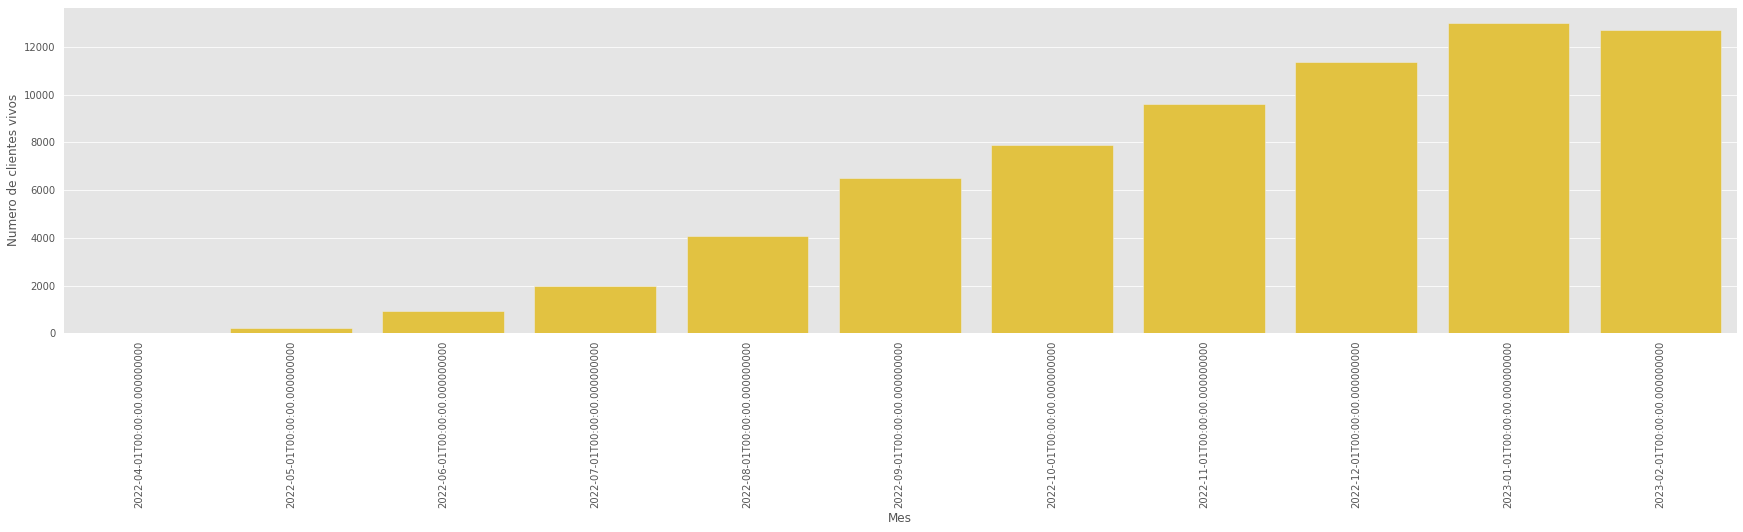

In [110]:
plt.figure(figsize=(30, 6))
sns.barplot(data=meses_df, x = 'Meses', y='conteo_vivos', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Numero de clientes vivos')
plt.xticks(rotation=90)
plt.show()

## a) Evolucion de los registros y de los importes de las facturas por mes

In [60]:
data_filt.head(1)

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Baja,Mes_Alta
22,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20,NaN,2022-09


In [61]:
data_filt['di_fecha_ven'].value_counts()

2023-01-23    2498
2023-02-20    2107
2022-10-03    1771
2023-01-02    1714
2022-11-03    1690
              ... 
2022-06-15       1
2022-06-24       1
2022-05-26       1
2022-06-02       1
2022-05-25       1
Name: di_fecha_ven, Length: 193, dtype: int64

In [62]:
data_filt['Mes_Emision']=data_filt['di_fecha_ven'].astype(str).str.slice(0,7)

In [63]:
numero_pagos=pd.DataFrame(data_filt['Mes_Emision'].value_counts().reset_index().sort_values('index'))
numero_pagos

,index,Mes_Emision
9,2022-05,9
8,2022-06,232
7,2022-07,608
6,2022-08,1583
5,2022-09,3152
4,2022-10,6544
3,2022-11,7963
2,2022-12,9680
1,2023-01,11624
0,2023-02,13322


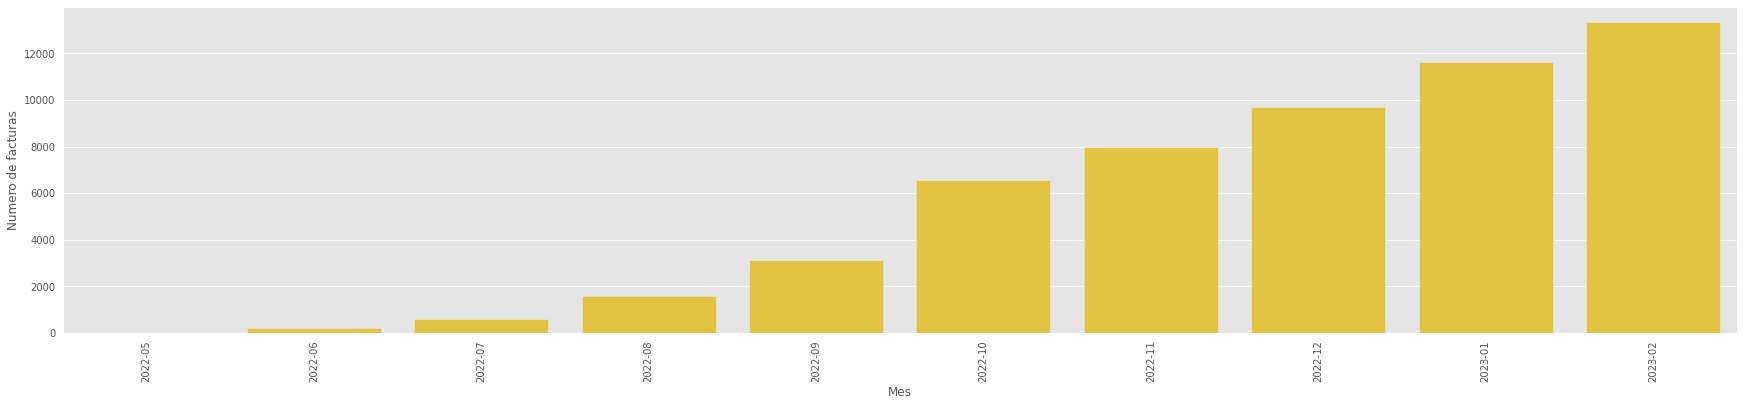

In [64]:
plt.figure(figsize=(30, 6))
sns.barplot(data=numero_pagos, x = 'index', y='Mes_Emision', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Numero de facturas')
plt.xticks(rotation=90)
plt.show()

In [68]:
# Impagados
Impagos = data_filt[data_filt['Impago']=='SI']

In [69]:
numero_impagos=pd.DataFrame(Impagos['Mes_Emision'].value_counts().reset_index().sort_values('index'))
numero_impagos

,index,Mes_Emision
9,2022-05,2
8,2022-06,36
7,2022-07,158
6,2022-08,335
5,2022-09,799
4,2022-10,1578
3,2022-11,2730
2,2022-12,3615
1,2023-01,4614
0,2023-02,5071


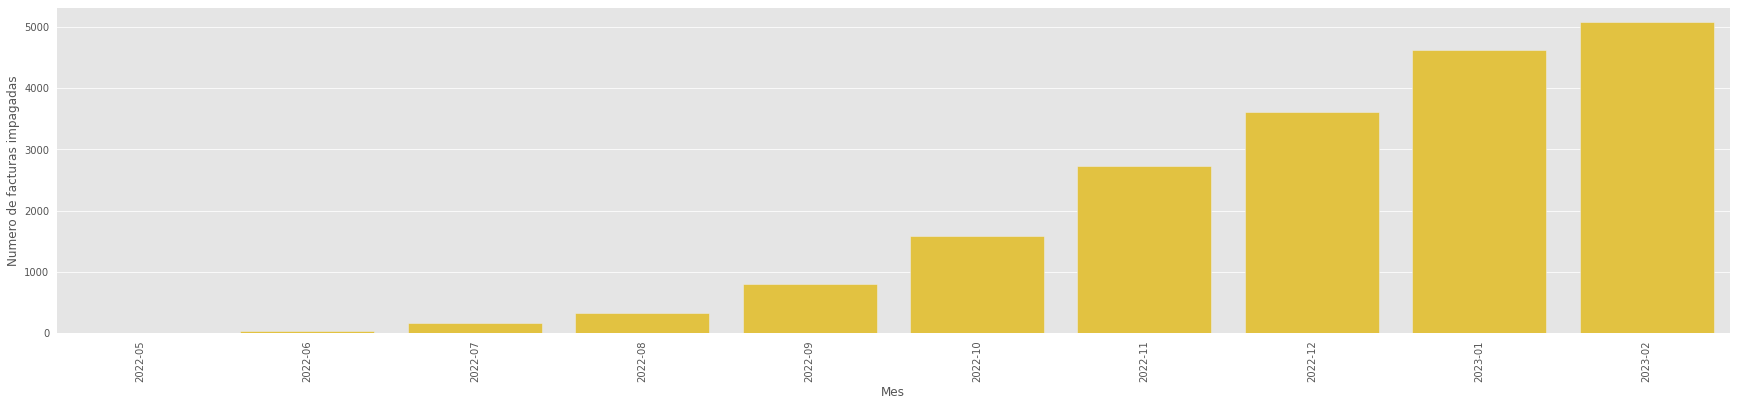

In [70]:
plt.figure(figsize=(30, 6))
sns.barplot(data=numero_impagos, x = 'index', y='Mes_Emision', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Numero de facturas impagadas')
plt.xticks(rotation=90)
plt.show()

In [109]:
data_filt.head(1)

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Baja,Mes_Alta,Mes_Emision,fecha_recuperacion,fecha_recuperacion_aux,dias_en_default,Default_1_dias,Default_90_dias,Default_90_dias_cont,Default_1_dias_cont,Default_90_dias_pers
0,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20,NaN,2022-09,2022-10,2022-10-29,2022-10-29,5,1,0,1,1,1


In [155]:
# Morosas
Morosas = data_filt[data_filt['Default_90_dias']==1]

In [156]:
numero_morosos=pd.DataFrame(Morosas['Mes_Emision'].value_counts().reset_index().sort_values('index'))
numero_morosos

,index,Mes_Emision
9,2022-05,2
8,2022-06,15
7,2022-07,25
6,2022-08,57
5,2022-09,127
4,2022-10,274
3,2022-11,504
2,2022-12,811
1,2023-01,1174
0,2023-02,1439


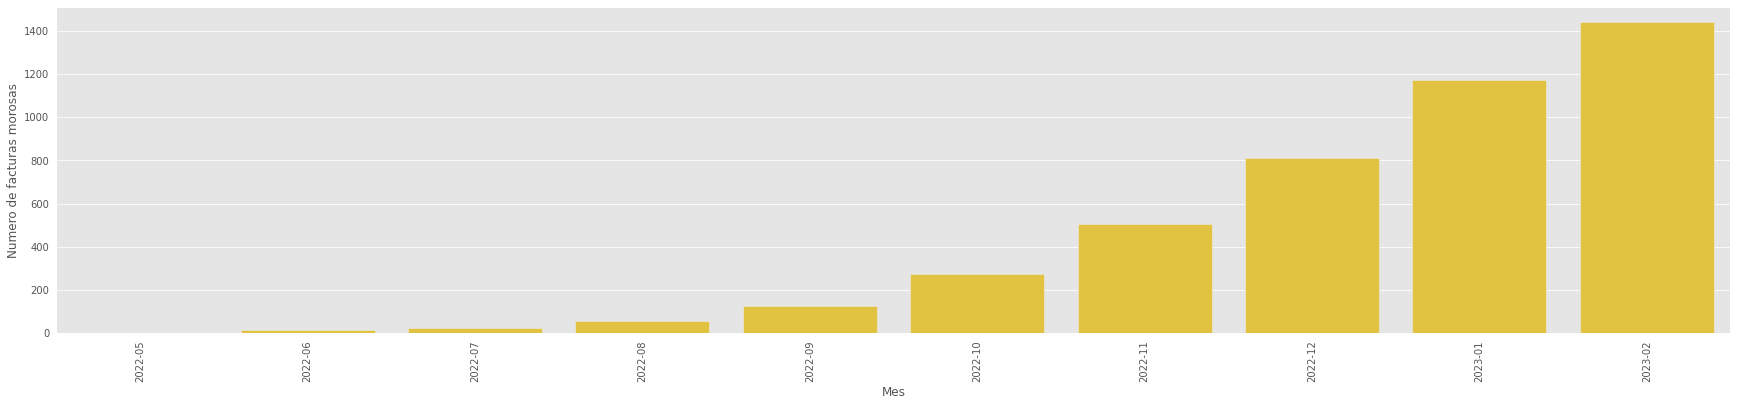

In [157]:
plt.figure(figsize=(30, 6))
sns.barplot(data=numero_morosos, x = 'index', y='Mes_Emision', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Numero de facturas morosas')
plt.xticks(rotation=90)
plt.show()

In [158]:
pagos_impagos = numero_pagos.merge(numero_impagos, how='inner', on='index')
pagos_impagos_morosos = pagos_impagos.merge(numero_morosos, how='inner', on='index')
pagos_impagos_morosos.rename(columns={'Mes_Emision_x':'numero_fac', 'Mes_Emision_y':'numero_fac_impagos', 'Mes_Emision':'numero_fac_morosas'}, inplace=True)

In [159]:
pagos_impagos_morosos.set_index('index', inplace=True)

In [160]:
pagos_impagos_morosos.head()

,numero_fac,numero_fac_impagos,numero_fac_morosas
index,,,
2022-05,9,2,2
2022-06,232,36,15
2022-07,608,158,25
2022-08,1583,335,57
2022-09,3152,799,127


In [161]:
pagos_impagos_morosos['porcentaje_impago'] = 100*pagos_impagos_morosos['numero_fac_impagos']/pagos_impagos_morosos['numero_fac']
pagos_impagos_morosos['porcentaje_mora'] = 100*pagos_impagos_morosos['numero_fac_morosas']/pagos_impagos_morosos['numero_fac']

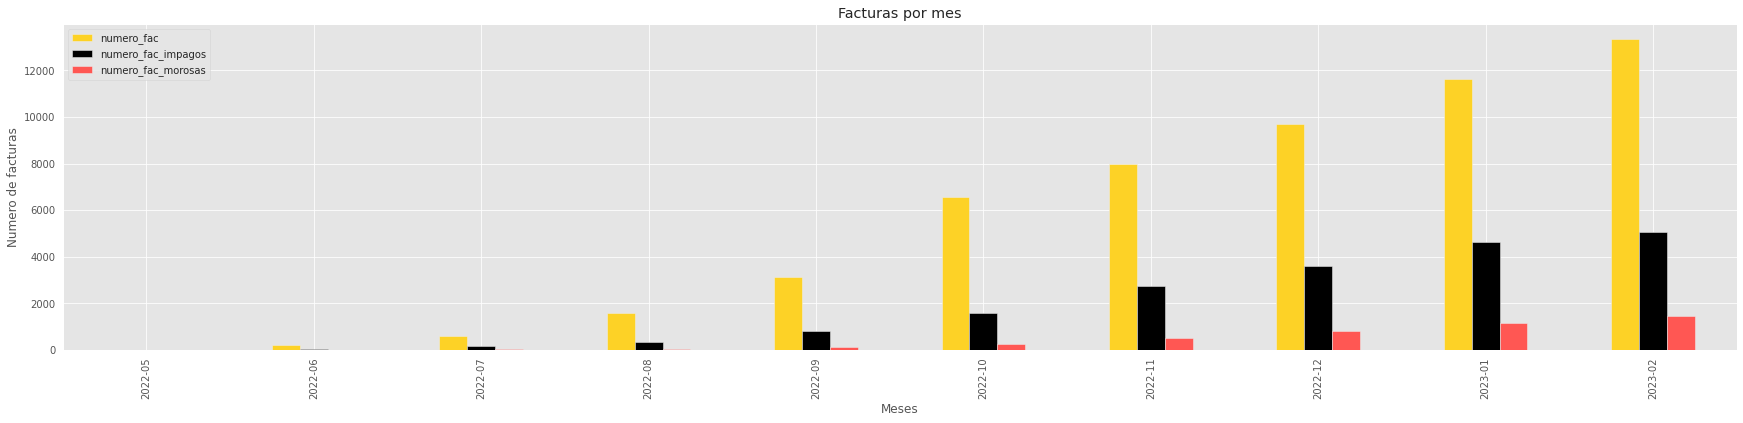

In [162]:
# Crear el gráfico de barras
colors = [HOCELOT_YELLOW, HOCELOT_BLACK, HOCELOT_RED]
pagos_impagos_morosos[['numero_fac','numero_fac_impagos','numero_fac_morosas']].plot(kind='bar', figsize=(30, 6), color=colors)
plt.xlabel('Meses')
plt.ylabel('Numero de facturas')
plt.title('Facturas por mes')
plt.legend()

meses = pagos_impagos_morosos.index.tolist()
plt.xticks(range(len(meses)), meses)

# Mostrar el gráfico
plt.show()

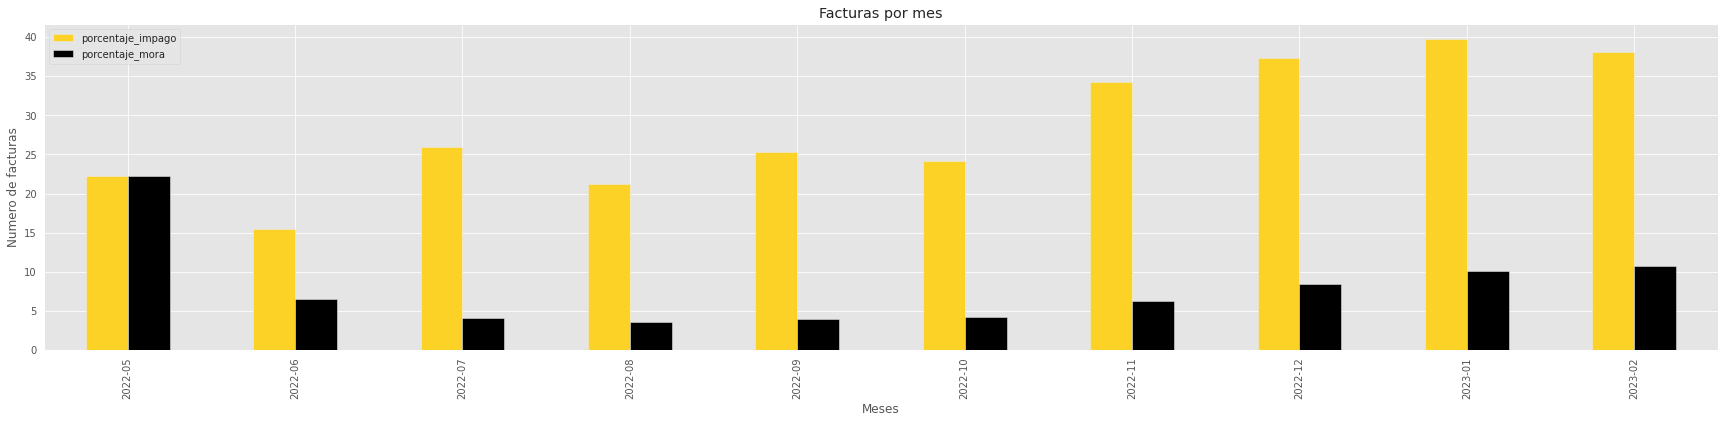

In [163]:
# Crear el gráfico de barras
colors = [HOCELOT_YELLOW, HOCELOT_BLACK]
pagos_impagos_morosos[['porcentaje_impago','porcentaje_mora']].plot(kind='bar', figsize=(30, 6), color=colors)
plt.xlabel('Meses')
plt.ylabel('Porcentajes de facturas sobre el total de facturas')
plt.title('Facturas por mes')
plt.legend()

meses = pagos_impagos_morosos.index.tolist()
plt.xticks(range(len(meses)), meses)

# Mostrar el gráfico
plt.show()

## Importes

In [198]:
Importe_por_mes = data_filt.fillna(0).groupby("Mes_Emision",as_index = False)['Cuota'].agg(sum)
Importe_por_mes

,Mes_Emision,Cuota
0,2022-05,31401.7900
1,2022-06,743865.4000
2,2022-07,2155486.6600
3,2022-08,5891033.5300
4,2022-09,12679243.8500
5,2022-10,27532846.2600
6,2022-11,34136836.3100
7,2022-12,43035334.2700
8,2023-01,52743542.4900
9,2023-02,61926748.6600


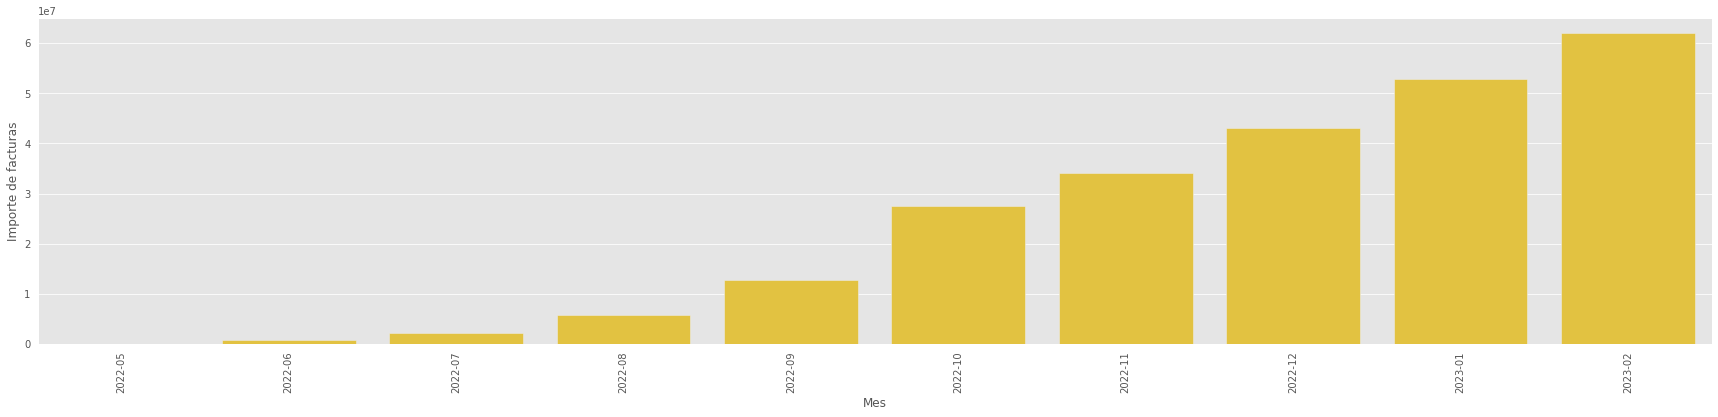

In [199]:
plt.figure(figsize=(30, 6))
sns.barplot(data=Importe_por_mes, x = 'Mes_Emision', y='Cuota', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Importe de facturas')
plt.xticks(rotation=90)
plt.show()

## b) Evolución de las facturas impagadas y recuperadas

In [251]:
data_filt.head(1)

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Baja,Mes_Alta,Mes_Emision,fecha_recuperacion,fecha_recuperacion_aux,dias_en_default,Default_1_dias,Default_90_dias,Default_90_dias_cont,Default_1_dias_cont,Default_90_dias_pers
0,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20,NaN,2022-09,2022-10,2022-10-29,2022-10-29,5,1,0,1,1,1


In [252]:
data_def=data_filt[data_filt['Default_1_dias']==1]

In [253]:
numero_impagos=pd.DataFrame(data_def['Mes_Emision'].value_counts().reset_index().sort_values('index'))
numero_impagos

,index,Mes_Emision
9,2022-05,2
8,2022-06,36
7,2022-07,158
6,2022-08,335
5,2022-09,799
4,2022-10,1578
3,2022-11,2730
2,2022-12,3615
1,2023-01,4614
0,2023-02,5071


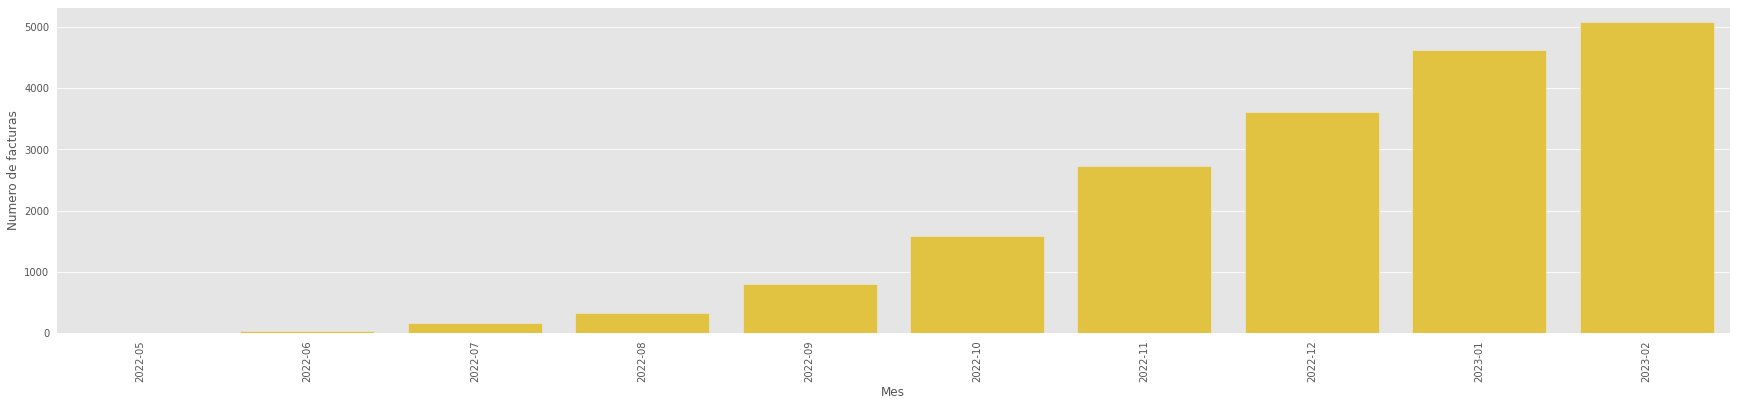

In [254]:
plt.figure(figsize=(30, 6))
sns.barplot(data=numero_impagos, x = 'index', y='Mes_Emision', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Numero de facturas')
plt.xticks(rotation=90)
plt.show()

In [255]:
data_filt.head(1)

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Baja,Mes_Alta,Mes_Emision,fecha_recuperacion,fecha_recuperacion_aux,dias_en_default,Default_1_dias,Default_90_dias,Default_90_dias_cont,Default_1_dias_cont,Default_90_dias_pers
0,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20,NaN,2022-09,2022-10,2022-10-29,2022-10-29,5,1,0,1,1,1


In [256]:
Impagado_por_mes = data_def.fillna(0).groupby("Mes_Emision",as_index = False)['Impagado'].agg(sum)
Impagado_por_mes

,Mes_Emision,Impagado
0,2022-05,7353.7900
1,2022-06,111635.9100
2,2022-07,521496.3200
3,2022-08,982173.0600
4,2022-09,2433734.8600
5,2022-10,4771526.2400
6,2022-11,8906660.6500
7,2022-12,11305232.5200
8,2023-01,14660682.7700
9,2023-02,15747579.0800


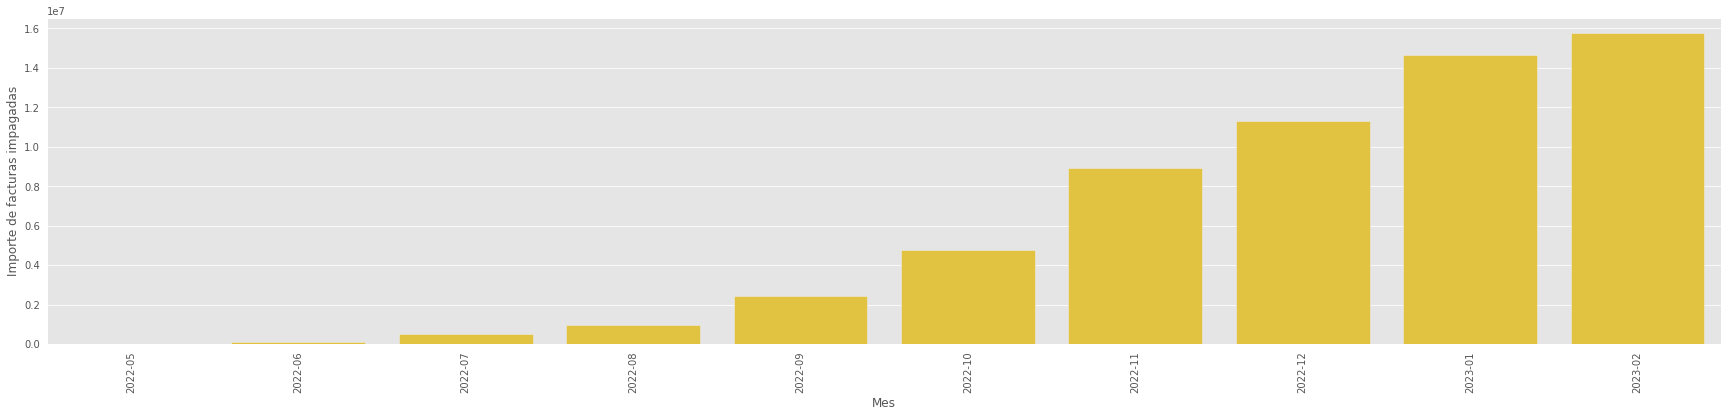

In [257]:
plt.figure(figsize=(30, 6))
sns.barplot(data=Impagado_por_mes, x = 'Mes_Emision', y='Impagado', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Importe de facturas impagadas')
plt.xticks(rotation=90)
plt.show()

In [258]:
Recuperado_por_mes = data_def.fillna(0).groupby("Mes_Emision",as_index = False)['Recuperado'].agg(sum)
Recuperado_por_mes

,Mes_Emision,Recuperado
0,2022-05,0.0000
1,2022-06,66094.5600
2,2022-07,437754.2200
3,2022-08,782160.1200
4,2022-09,1912916.7900
5,2022-10,3706394.9700
6,2022-11,6862343.4200
7,2022-12,8030434.5600
8,2023-01,9854453.1600
9,2023-02,9621538.3800


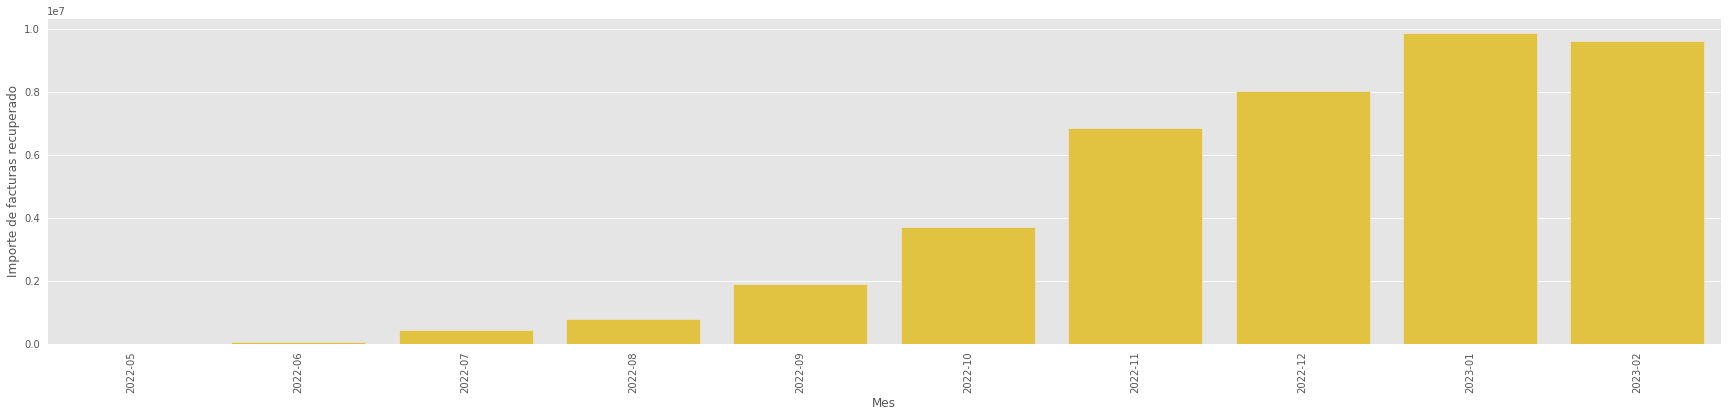

In [259]:
plt.figure(figsize=(30, 6))
sns.barplot(data=Recuperado_por_mes, x = 'Mes_Emision', y='Recuperado', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Importe de facturas recuperado')
plt.xticks(rotation=90)
plt.show()

### Importes impagado tecnico

In [260]:
Importe_por_mes

,Mes_Emision,Cuota
0,2022-05,31401.7900
1,2022-06,743865.4000
2,2022-07,2155486.6600
3,2022-08,5891033.5300
4,2022-09,12679243.8500
5,2022-10,27532846.2600
6,2022-11,34136836.3100
7,2022-12,43035334.2700
8,2023-01,52743542.4900
9,2023-02,61926748.6600


In [261]:
Impagado_por_mes

,Mes_Emision,Impagado
0,2022-05,7353.7900
1,2022-06,111635.9100
2,2022-07,521496.3200
3,2022-08,982173.0600
4,2022-09,2433734.8600
5,2022-10,4771526.2400
6,2022-11,8906660.6500
7,2022-12,11305232.5200
8,2023-01,14660682.7700
9,2023-02,15747579.0800


In [262]:
Recuperado_por_mes

,Mes_Emision,Recuperado
0,2022-05,0.0000
1,2022-06,66094.5600
2,2022-07,437754.2200
3,2022-08,782160.1200
4,2022-09,1912916.7900
5,2022-10,3706394.9700
6,2022-11,6862343.4200
7,2022-12,8030434.5600
8,2023-01,9854453.1600
9,2023-02,9621538.3800


In [276]:
imp_pagos_impagos = Importe_por_mes.merge(Impagado_por_mes, how='inner', on='Mes_Emision')
imp_pagos_impagos_morosos = imp_pagos_impagos.merge(Recuperado_por_mes, how='inner', on='Mes_Emision')
imp_pagos_impagos_morosos.rename(columns={'Mes_Emision_x':'importe_fac', 'Mes_Emision_y':'importe_fac_impagos', 'Mes_Emision':'imp_fac_recuperado'}, inplace=True)

In [264]:
imp_pagos_impagos_morosos

,imp_fac_morosas,Cuota,Impagado,Recuperado
0,2022-05,31401.7900,7353.7900,0.0000
1,2022-06,743865.4000,111635.9100,66094.5600
2,2022-07,2155486.6600,521496.3200,437754.2200
3,2022-08,5891033.5300,982173.0600,782160.1200
4,2022-09,12679243.8500,2433734.8600,1912916.7900
5,2022-10,27532846.2600,4771526.2400,3706394.9700
6,2022-11,34136836.3100,8906660.6500,6862343.4200
7,2022-12,43035334.2700,11305232.5200,8030434.5600
8,2023-01,52743542.4900,14660682.7700,9854453.1600
9,2023-02,61926748.6600,15747579.0800,9621538.3800


In [265]:
imp_pagos_impagos_morosos['porcentaje_impago'] = 100*imp_pagos_impagos_morosos['Impagado']/imp_pagos_impagos_morosos['Cuota']
imp_pagos_impagos_morosos['porcentaje_recuperacion'] = 100*imp_pagos_impagos_morosos['Recuperado']/imp_pagos_impagos_morosos['Cuota']

In [266]:
imp_pagos_impagos_morosos.set_index('imp_fac_morosas', inplace=True)

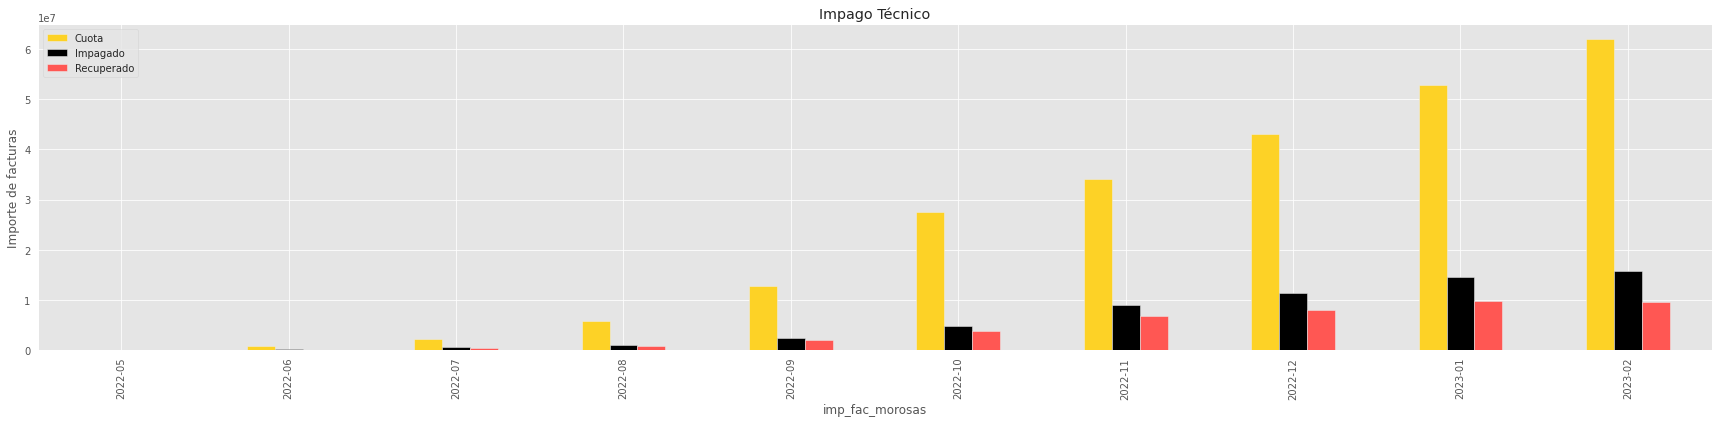

In [267]:
# Crear el gráfico de barras
colors = [HOCELOT_YELLOW, HOCELOT_BLACK, HOCELOT_RED]
imp_pagos_impagos_morosos[['Cuota','Impagado','Recuperado']].plot(kind='bar', figsize=(30, 6), color=colors)
plt.xlabel('imp_fac_morosas')
plt.ylabel('Importe de facturas')
plt.title('Impago Técnico')
plt.legend()

meses = imp_pagos_impagos_morosos.index.tolist()
plt.xticks(range(len(meses)), meses)

# Mostrar el gráfico
plt.show()

In [268]:
imp_pagos_impagos_morosos

,Cuota,Impagado,Recuperado,porcentaje_impago,porcentaje_recuperacion
imp_fac_morosas,,,,,
2022-05,31401.7900,7353.7900,0.0000,23.4184,0.0000
2022-06,743865.4000,111635.9100,66094.5600,15.0075,8.8853
2022-07,2155486.6600,521496.3200,437754.2200,24.1939,20.3088
2022-08,5891033.5300,982173.0600,782160.1200,16.6723,13.2771
2022-09,12679243.8500,2433734.8600,1912916.7900,19.1946,15.0870
2022-10,27532846.2600,4771526.2400,3706394.9700,17.3303,13.4617
2022-11,34136836.3100,8906660.6500,6862343.4200,26.0911,20.1025
2022-12,43035334.2700,11305232.5200,8030434.5600,26.2697,18.6601
2023-01,52743542.4900,14660682.7700,9854453.1600,27.7962,18.6837


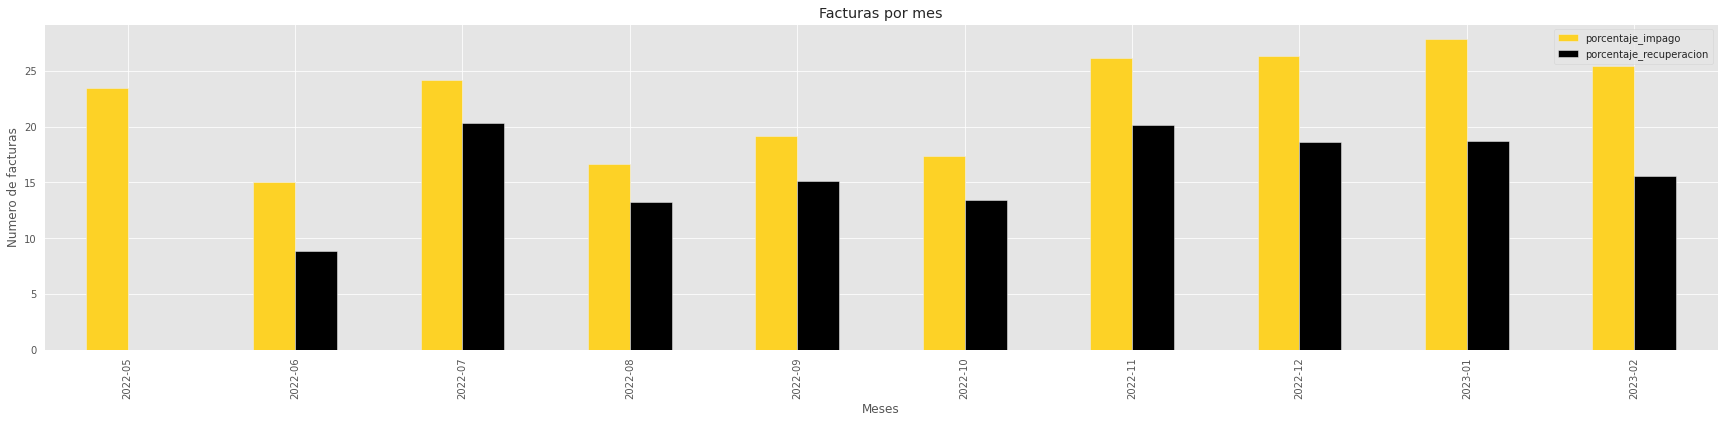

In [269]:
# Crear el gráfico de barras
colors = [HOCELOT_YELLOW, HOCELOT_BLACK]
imp_pagos_impagos_morosos[['porcentaje_impago','porcentaje_recuperacion']].plot(kind='bar', figsize=(30, 6), color=colors)
plt.xlabel('Meses')
plt.ylabel('Porcenta de importe de facturas')
plt.title('Facturas por mes')
plt.legend()

meses = pagos_impagos_morosos.index.tolist()
plt.xticks(range(len(meses)), meses)

# Mostrar el gráfico
plt.show()

### MORA

In [54]:
data_filt.head(2)

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Emision,fecha_recuperacion,fecha_recuperacion_aux,dias_en_default,Default_1_dias,Default_90_dias,Default_90_dias_cont,Default_1_dias_cont,Default_90_dias_pers
0,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20,2022-10,2022-10-29,2022-10-29,5,1,0,1,1,1
1,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-10-25,2022-11-22,2,3360.3400,SI,3360.3400,129.3400,129.3400,2022-12-22,20,2022-11,2022-12-22,2022-12-22,30,1,0,1,1,1


In [285]:
data_def=data_filt[data_filt['Default_90_dias']==1]

In [286]:
numero_mora=pd.DataFrame(data_def['Mes_Emision'].value_counts().reset_index().sort_values('index'))
numero_mora

,index,Mes_Emision
9,2022-05,2
8,2022-06,15
7,2022-07,25
6,2022-08,57
5,2022-09,127
4,2022-10,274
3,2022-11,504
2,2022-12,811
1,2023-01,1174
0,2023-02,1439


In [287]:
Impagado_por_mes = data_def.fillna(0).groupby("Mes_Emision",as_index = False)['Impagado'].agg(sum)
Impagado_por_mes

,Mes_Emision,Impagado
0,2022-05,7353.7900
1,2022-06,47574.0600
2,2022-07,91955.9800
3,2022-08,226128.4300
4,2022-09,554648.5900
5,2022-10,1146238.3000
6,2022-11,2141632.1700
7,2022-12,3483248.1800
8,2023-01,5139809.3600
9,2023-02,6439289.2600


In [288]:
Recuperado_por_mes = data_def.fillna(0).groupby("Mes_Emision",as_index = False)['Recuperado'].agg(sum)
Recuperado_por_mes

,Mes_Emision,Recuperado
0,2022-05,0.0000
1,2022-06,2032.7100
2,2022-07,8161.1800
3,2022-08,25944.0700
4,2022-09,33687.7200
5,2022-10,81018.8900
6,2022-11,97220.9200
7,2022-12,208370.0400
8,2023-01,330395.7500
9,2023-02,309141.7600


In [289]:
imp_pagos_impagos = Importe_por_mes.merge(Impagado_por_mes, how='inner', on='Mes_Emision')
imp_pagos_impagos_morosos = imp_pagos_impagos.merge(Recuperado_por_mes, how='inner', on='Mes_Emision')
imp_pagos_impagos_morosos.rename(columns={'Mes_Emision_x':'importe_fac', 'Mes_Emision_y':'importe_fac_impagos'}, inplace=True)

In [290]:
imp_pagos_impagos_morosos['porcentaje_impago'] = 100*imp_pagos_impagos_morosos['Impagado']/imp_pagos_impagos_morosos['Cuota']
imp_pagos_impagos_morosos['porcentaje_recuperacion'] = 100*imp_pagos_impagos_morosos['Recuperado']/imp_pagos_impagos_morosos['Cuota']

In [291]:
imp_pagos_impagos_morosos

,Mes_Emision,Cuota,Impagado,Recuperado,porcentaje_impago,porcentaje_recuperacion
0,2022-05,31401.7900,7353.7900,0.0000,23.4184,0.0000
1,2022-06,743865.4000,47574.0600,2032.7100,6.3955,0.2733
2,2022-07,2155486.6600,91955.9800,8161.1800,4.2661,0.3786
3,2022-08,5891033.5300,226128.4300,25944.0700,3.8385,0.4404
4,2022-09,12679243.8500,554648.5900,33687.7200,4.3745,0.2657
5,2022-10,27532846.2600,1146238.3000,81018.8900,4.1632,0.2943
6,2022-11,34136836.3100,2141632.1700,97220.9200,6.2737,0.2848
7,2022-12,43035334.2700,3483248.1800,208370.0400,8.0939,0.4842
8,2023-01,52743542.4900,5139809.3600,330395.7500,9.7449,0.6264
9,2023-02,61926748.6600,6439289.2600,309141.7600,10.3982,0.4992


In [292]:
imp_pagos_impagos_morosos.set_index('Mes_Emision', inplace=True)

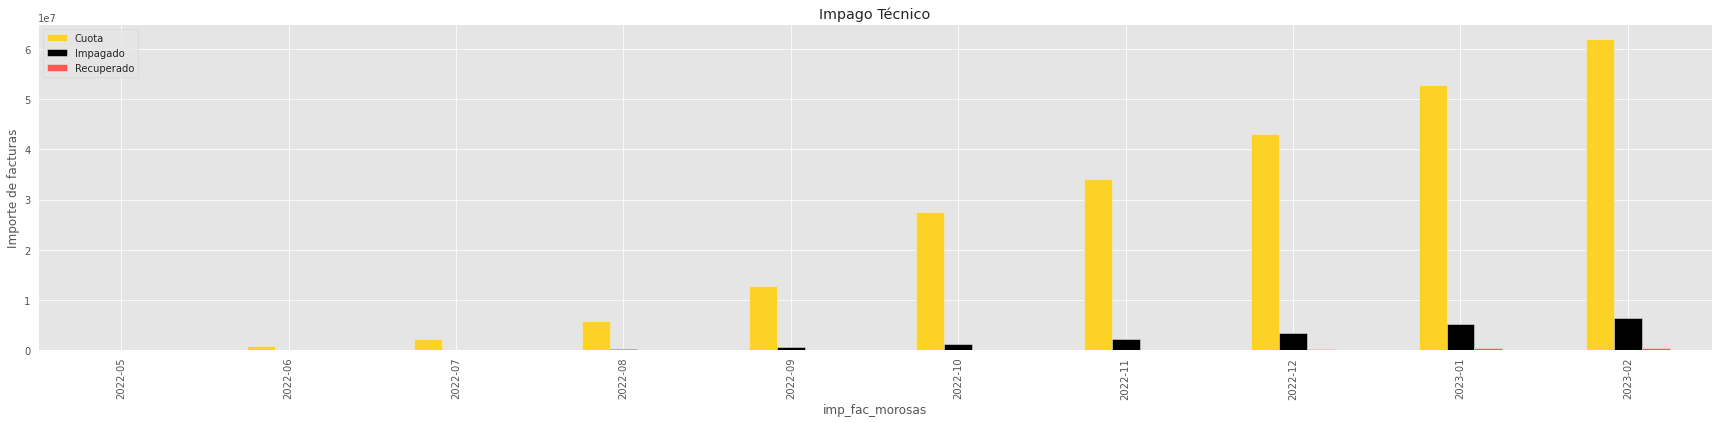

In [293]:
# Crear el gráfico de barras
colors = [HOCELOT_YELLOW, HOCELOT_BLACK, HOCELOT_RED]
imp_pagos_impagos_morosos[['Cuota','Impagado','Recuperado']].plot(kind='bar', figsize=(30, 6), color=colors)
plt.xlabel('imp_fac_morosas')
plt.ylabel('Importe de facturas')
plt.title('Impago Técnico')
plt.legend()

meses = imp_pagos_impagos_morosos.index.tolist()
plt.xticks(range(len(meses)), meses)

# Mostrar el gráfico
plt.show()

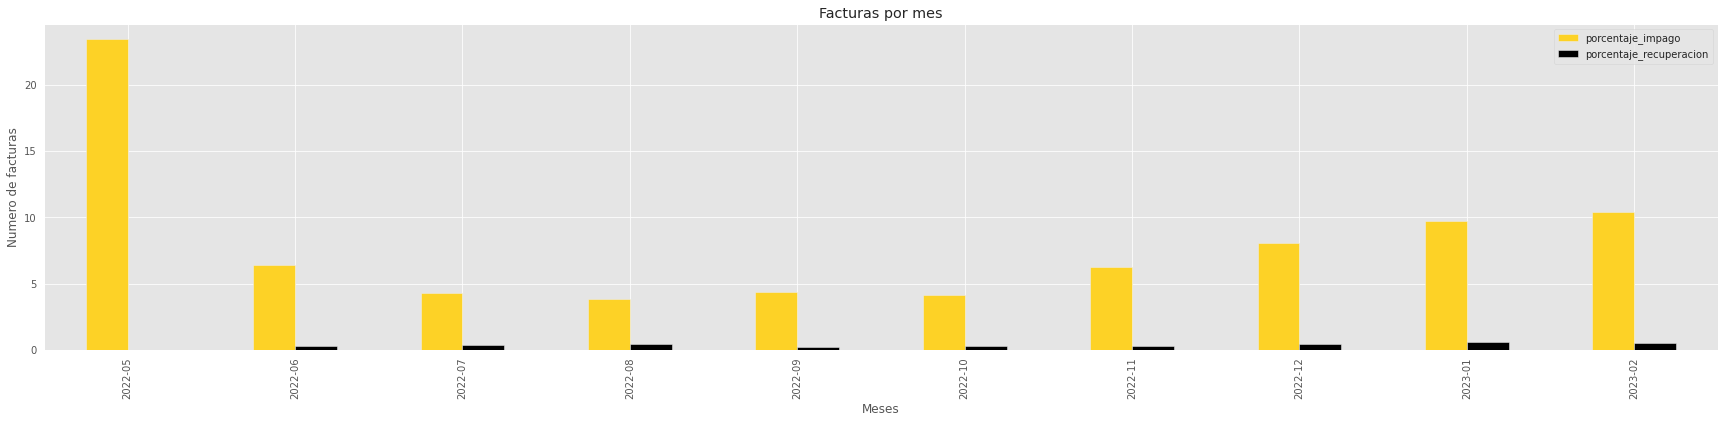

In [294]:
# Crear el gráfico de barras
colors = [HOCELOT_YELLOW, HOCELOT_BLACK]
imp_pagos_impagos_morosos[['porcentaje_impago','porcentaje_recuperacion']].plot(kind='bar', figsize=(30, 6), color=colors)
plt.xlabel('Meses')
plt.ylabel('Numero de facturas')
plt.title('Facturas por mes')
plt.legend()

meses = pagos_impagos_morosos.index.tolist()
plt.xticks(range(len(meses)), meses)

# Mostrar el gráfico
plt.show()

Ratio de conversion de impago tecnico a morosas
Total facturas mora / Total de facturas impagadas por mes 
Sacar por facturas y por importes
LGD por meses

Porcentaje de impago y de mora

# Ratio de conversion por mes

In [55]:
data_filt.head(2)

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Emision,fecha_recuperacion,fecha_recuperacion_aux,dias_en_default,Default_1_dias,Default_90_dias,Default_90_dias_cont,Default_1_dias_cont,Default_90_dias_pers
0,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20,2022-10,2022-10-29,2022-10-29,5,1,0,1,1,1
1,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-10-25,2022-11-22,2,3360.3400,SI,3360.3400,129.3400,129.3400,2022-12-22,20,2022-11,2022-12-22,2022-12-22,30,1,0,1,1,1


In [56]:
data_filt_sel = data_filt[['NoCredito','NoCliente','Mes_Emision','Impagado','Recuperado','Default_1_dias','Default_90_dias']]
data_filt_sel

,NoCredito,NoCliente,Mes_Emision,Impagado,Recuperado,Default_1_dias,Default_90_dias
0,39792683,48993,2022-10,3231.6900,3231.6900,1,0
1,39792683,48993,2022-11,129.3400,129.3400,1,0
2,39792683,48993,2022-12,3314.9600,3314.9600,1,0
3,39792683,48993,2023-01,3840.4100,0.0000,1,1
4,39792683,48993,2023-02,3864.7500,0.0000,1,1
...,...,...,...,...,...,...,...
54712,960899951,999855075,2022-12,0.0000,0.0000,0,0
54713,960899951,999855075,2023-01,1522.9300,1522.9300,1,0
54714,960899951,999855075,2023-02,22.4200,22.4200,1,0
54715,776116931,999949417,2023-02,5488.4600,5488.4600,1,0


In [115]:
data_filt_sel_1 = data_filt_sel[data_filt_sel['Default_1_dias']==1]
data_filt_sel_1

,NoCredito,NoCliente,Mes_Emision,Impagado,Recuperado,Default_1_dias,Default_90_dias
0,39792683,48993,2022-10,3231.6900,3231.6900,1,0
1,39792683,48993,2022-11,129.3400,129.3400,1,0
2,39792683,48993,2022-12,3314.9600,3314.9600,1,0
3,39792683,48993,2023-01,3840.4100,0.0000,1,1
4,39792683,48993,2023-02,3864.7500,0.0000,1,1
...,...,...,...,...,...,...,...
54704,913974411,999745411,2023-02,2523.7400,2523.7400,1,0
54713,960899951,999855075,2023-01,1522.9300,1522.9300,1,0
54714,960899951,999855075,2023-02,22.4200,22.4200,1,0
54715,776116931,999949417,2023-02,5488.4600,5488.4600,1,0


In [116]:
agrupado_1 = data_filt_sel_1.groupby('Mes_Emision').agg({'Default_1_dias':'sum'})
agrupado_2 = data_filt_sel_1.groupby('Mes_Emision').agg({'Default_90_dias':'sum'})
agrupado_3 = data_filt_sel_1.groupby('Mes_Emision').agg({'Impagado':'sum'})
agrupado_4 = data_filt_sel_1.groupby('Mes_Emision').agg({'Recuperado':'sum'})

In [117]:
agrupado = agrupado_1.merge(agrupado_2, how='inner', on='Mes_Emision')

In [118]:
agrupado['Ratio_num_fact_impago_mora'] = 100*agrupado['Default_90_dias']/agrupado['Default_1_dias']

In [119]:
agrupado = agrupado.merge(agrupado_3, how='inner', on='Mes_Emision')
agrupado = agrupado.merge(agrupado_4, how='inner', on='Mes_Emision')

In [120]:
agrupado['LGD_tecnico'] = 100-100*agrupado['Recuperado']/agrupado['Impagado']

In [121]:
data_filt_sel_2 = data_filt_sel[data_filt_sel['Default_90_dias']==1]

In [122]:
agrupado_5 = data_filt_sel_2.groupby('Mes_Emision').agg({'Impagado':'sum'})
agrupado_6 = data_filt_sel_2.groupby('Mes_Emision').agg({'Recuperado':'sum'})

In [123]:
agrupado = agrupado.merge(agrupado_5, how='inner', on='Mes_Emision')
agrupado = agrupado.merge(agrupado_6, how='inner', on='Mes_Emision')

In [124]:
agrupado.rename(columns={'Impagado_x':'Impagado_tecnico','Recuperado_x':'Recuperado_tecnico','Impagado_y':'Impagado_90','Recuperado_y':'Recuperado_90'}, inplace=True)

In [125]:
agrupado['LGD_90'] = (100-100*agrupado['Recuperado_90']/agrupado['Impagado_90'])

In [126]:
agrupado['Ratio_importe_impago_mora'] = 100*agrupado['Impagado_90']/agrupado['Impagado_tecnico']

In [127]:
agrupado

,Default_1_dias,Default_90_dias,Ratio_num_fact_impago_mora,Impagado_tecnico,Recuperado_tecnico,LGD_tecnico,Impagado_90,Recuperado_90,LGD_90,Ratio_importe_impago_mora
Mes_Emision,,,,,,,,,,
2022-05,2,2,100.0000,7353.7900,0.0000,100.0000,7353.7900,0.0000,100.0000,100.0000
2022-06,36,15,41.6667,111635.9100,66094.5600,40.7945,47574.0600,2032.7100,95.7273,42.6154
2022-07,158,25,15.8228,521496.3200,437754.2200,16.0580,91955.9800,8161.1800,91.1249,17.6331
2022-08,335,57,17.0149,982173.0600,782160.1200,20.3643,226128.4300,25944.0700,88.5268,23.0233
2022-09,799,127,15.8949,2433734.8600,1912916.7900,21.4000,554648.5900,33687.7200,93.9263,22.7900
2022-10,1578,274,17.3638,4771526.2400,3706394.9700,22.3227,1146238.3000,81018.8900,92.9318,24.0225
2022-11,2730,504,18.4615,8906660.6500,6862343.4200,22.9527,2141632.1700,97220.9200,95.4604,24.0453
2022-12,3615,811,22.4343,11305232.5200,8030434.5600,28.9671,3483248.1800,208370.0400,94.0179,30.8109
2023-01,4614,1174,25.4443,14660682.7700,9854453.1600,32.7831,5139809.3600,330395.7500,93.5718,35.0585


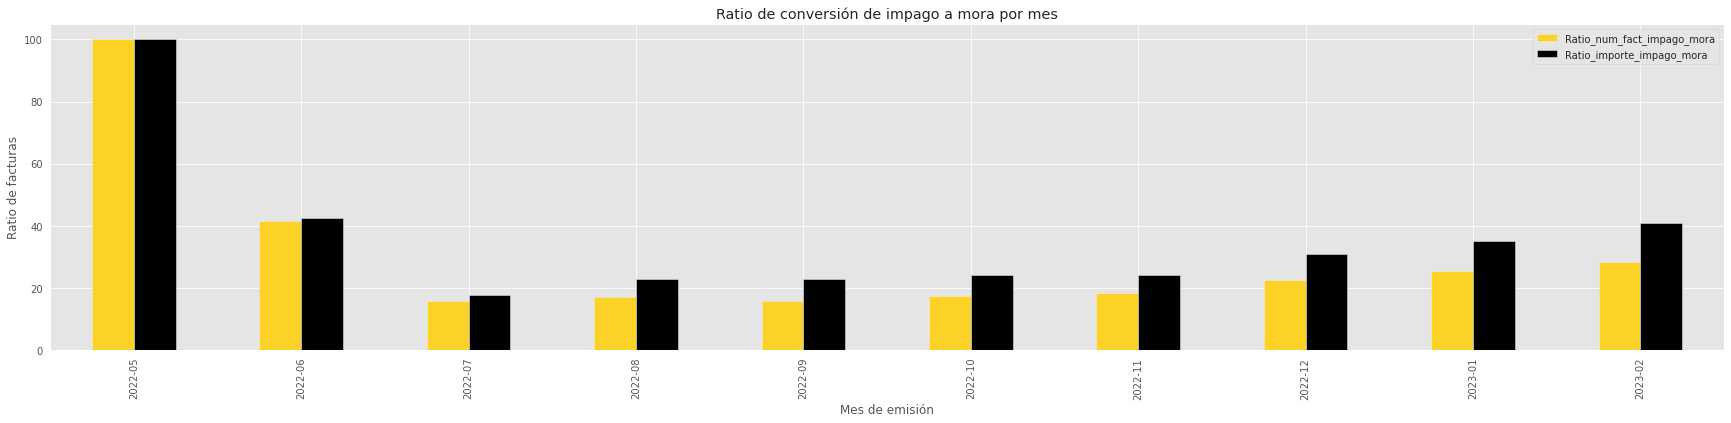

In [128]:
# Crear el gráfico de barras
colors = [HOCELOT_YELLOW, HOCELOT_BLACK, HOCELOT_RED]
agrupado[['Ratio_num_fact_impago_mora','Ratio_importe_impago_mora']].plot(kind='bar', figsize=(30, 6), color=colors)
plt.xlabel('Mes de emisión')
plt.ylabel('Ratio de facturas')
plt.title('Ratio de conversión de impago a mora por mes')
plt.legend()

#meses = pagos_impagos_morosos.index.tolist()
#plt.xticks(range(len(meses)), meses)

# Mostrar el gráfico
plt.show()

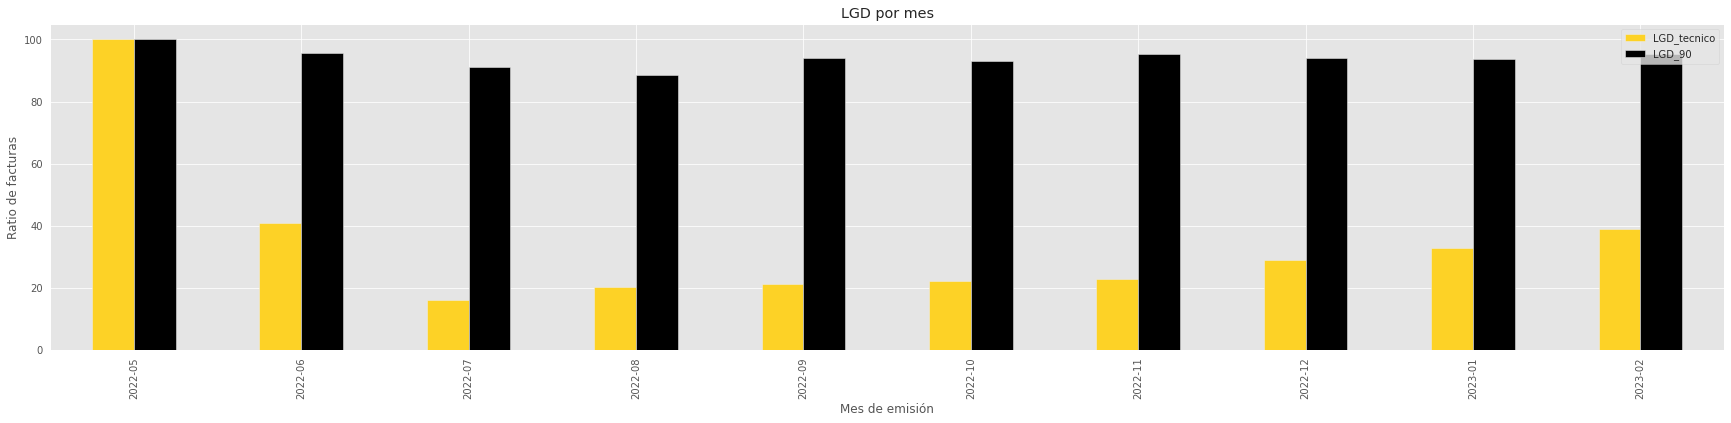

In [129]:
# Crear el gráfico de barras
colors = [HOCELOT_YELLOW, HOCELOT_BLACK, HOCELOT_RED]
agrupado[['LGD_tecnico','LGD_90']].plot(kind='bar', figsize=(30, 6), color=colors)
plt.xlabel('Mes de emisión')
plt.ylabel('Ratio de facturas')
plt.title('LGD por mes')
plt.legend()

#meses = pagos_impagos_morosos.index.tolist()
#plt.xticks(range(len(meses)), meses)

# Mostrar el gráfico
plt.show()

Tasa de impago en los meses finales (los eliminados) en importe (les aplicamos el 45% y ese sera el importe en mora esperado) sacar tambien perdida esperada considerando LGD = 93%

In [135]:
data_filt_post = data[(data['di_fecha_ven']>'2023-02-28')&(data['di_fecha_ven']<='2023-05-31')]
print(data_filt_post.shape)
data_filt_post.head()

(57943, 31)


,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,TipoProducto,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago
0,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO,Crédito Micro-Empresario,22440.0000,12,114.0000,2023-03-08,NaN,3460.0000,Mensual,"Aprobado, verde",2023-03-07,2023-04-10,1,3460.0000,NO,3460.0000,0.0000,0.0000,2023-04-10
1,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO,Crédito Micro-Empresario,22440.0000,12,114.0000,2023-03-08,NaN,3460.0000,Mensual,"Aprobado, verde",2023-04-11,2023-05-08,2,3491.9500,SI,3491.9500,3451.9500,3451.9500,2023-05-16
12,1994129,41771,ARELY GARCIA MENDEZ,1991-03-29,GAMA910329MCSRNR07,CALLE SIN NOMBRE,sn,ESTRRELLA ROJA,SOCOLTENANGO,CHIAPAS,eg145972@gmail.com,9921435866,SOLTERO,Crédito Micro-Empresario,12700.0000,10,120.0000,2023-03-17,NaN,2216.4800,Mensual,"Aprobado, verde",2023-03-17,2023-04-17,1,2217.1000,SI,2217.1000,2216.1900,2216.1900,2023-04-19
13,1994129,41771,ARELY GARCIA MENDEZ,1991-03-29,GAMA910329MCSRNR07,CALLE SIN NOMBRE,sn,ESTRRELLA ROJA,SOCOLTENANGO,CHIAPAS,eg145972@gmail.com,9921435866,SOLTERO,Crédito Micro-Empresario,12700.0000,10,120.0000,2023-03-17,NaN,2216.4800,Mensual,"Aprobado, verde",2023-04-18,2023-05-17,2,2220.3700,SI,2220.3700,2140.7400,2140.7400,2023-05-18
27,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,Crédito Micro-Empresario,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2023-02-23,2023-03-22,6,3906.5100,SI,0.0000,3906.5100,0.0000,NaN


In [136]:
data_filt_post['Mes_Emision']=data_filt_post['di_fecha_ven'].astype(str).str.slice(0,7)

In [140]:
data_filt_post['fecha_recuperacion'] = np.where((data_filt_post['Fecha Ultimo Pago'] > data_filt_post['di_fecha_ven'])&(data_filt_post['Impagado'] <= data_filt_post['Recuperado']), data_filt_post['Fecha Ultimo Pago'], np.nan)

In [142]:
data_filt_post['fecha_recuperacion_aux'] = np.where(data_filt_post['fecha_recuperacion'].notnull(),data_filt_post['fecha_recuperacion'], '2023-05-31')

In [144]:
data_filt_post['fecha_recuperacion_aux'] = pd.to_datetime(data_filt_post['fecha_recuperacion_aux'])
data_filt_post['di_fecha_ven'] = pd.to_datetime(data_filt['di_fecha_ven'])
data_filt_post['dias_en_default']=np.where(data_filt_post['Impago']=='SI' , 
                                     data_filt_post['fecha_recuperacion_aux'] - data_filt_post['di_fecha_ven'] , 
                                     data_filt_post['fecha_recuperacion_aux'] - data_filt_post['fecha_recuperacion_aux'])
data_filt_post['dias_en_default'] = pd.to_numeric(data_filt_post['dias_en_default'].dropna().astype(str).str.split(' ').apply(lambda x: x[0]))

In [145]:
data_filt_post['Default_1_dias'] = np.where(data_filt_post['dias_en_default']>0, 1, 0)
print('Numero de facturas con mas de 1 dias de atraso: {}'.format(data_filt_post['Default_1_dias'].sum()))
print('Porcentaje de facturas con mas de 1 dias de atraso: {}'.format(100*(data_filt_post['Default_1_dias'].sum()/data_filt_post['Default_1_dias'].shape[0])))
print('Porcentaje de dinero impagado mas de 1 dias de atraso: {}'.format(100*(data_filt_post[data_filt_post['Default_1_dias']>0]['Impagado'].sum()/data_filt_post['Cuota'].sum())))

Numero de facturas con mas de 1 dias de atraso: 4057
Porcentaje de facturas con mas de 1 dias de atraso: 7.001708575669192
Porcentaje de dinero impagado mas de 1 dias de atraso: 5.266441293962439


In [174]:
data_filt_post_sel = data_filt_post[['NoCredito','NoCliente','Mes_Emision','Cuota','Impagado','Recuperado','Default_1_dias']]
data_filt_post_sel

,NoCredito,NoCliente,Mes_Emision,Cuota,Impagado,Recuperado,Default_1_dias
0,1920492,35447,2023-04,3460.0000,0.0000,0.0000,0
1,1920492,35447,2023-05,3491.9500,3451.9500,3451.9500,1
12,1994129,41771,2023-04,2217.1000,2216.1900,2216.1900,1
13,1994129,41771,2023-05,2220.3700,2140.7400,2140.7400,1
27,39792683,48993,2023-03,3906.5100,3906.5100,0.0000,1
...,...,...,...,...,...,...,...
300871,776116931,999949417,2023-05,5463.0000,0.0000,0.0000,0
300882,64755949,999954880,2023-03,5919.7300,152.7300,152.7300,0
300883,64755949,999954880,2023-04,6046.0000,96.0000,96.0000,0
300884,64755949,999954880,2023-05,6113.4700,6017.4800,0.0000,0


In [175]:
agrupado_post_1 = data_filt_post_sel.groupby('Mes_Emision').agg({'Impagado':'sum'})
agrupado_post_2 = data_filt_post_sel.groupby('Mes_Emision').agg({'Cuota':'sum'})

In [176]:
agrupado_post_1 = agrupado_post_1.merge(agrupado_post_2, how='inner', on='Mes_Emision')
agrupado_post_1

,Impagado,Cuota
Mes_Emision,,
2023-03,19457886.8300,75145084.6700
2023-04,24626205.5200,88702516.6800
2023-05,32289433.7900,102733909.5100


In [177]:
agrupado_post_1['Tasa_impago'] = 100*agrupado_post_1['Impagado']/agrupado_post_1['Cuota']
agrupado_post_1

,Impagado,Cuota,Tasa_impago
Mes_Emision,,,
2023-03,19457886.8300,75145084.6700,25.8938
2023-04,24626205.5200,88702516.6800,27.7627
2023-05,32289433.7900,102733909.5100,31.4302


In [178]:
agrupado_post_1['Tasa_mora_estimada'] = 0.45*agrupado_post_1['Tasa_impago']
agrupado_post_1

,Impagado,Cuota,Tasa_impago,Tasa_mora_estimada
Mes_Emision,,,,
2023-03,19457886.8300,75145084.6700,25.8938,11.6522
2023-04,24626205.5200,88702516.6800,27.7627,12.4932
2023-05,32289433.7900,102733909.5100,31.4302,14.1436


In [179]:
agrupado_post_1['Tasa_perdida_esperada'] = 0.93*agrupado_post_1['Tasa_mora_estimada']
agrupado_post_1

,Impagado,Cuota,Tasa_impago,Tasa_mora_estimada,Tasa_perdida_esperada
Mes_Emision,,,,,
2023-03,19457886.8300,75145084.6700,25.8938,11.6522,10.8365
2023-04,24626205.5200,88702516.6800,27.7627,12.4932,11.6187
2023-05,32289433.7900,102733909.5100,31.4302,14.1436,13.1535


In [180]:
agrupado_post_1['Perdida_esperada'] = agrupado_post_1['Cuota']*agrupado_post_1['Tasa_perdida_esperada']
agrupado_post_1

,Impagado,Cuota,Tasa_impago,Tasa_mora_estimada,Tasa_perdida_esperada,Perdida_esperada
Mes_Emision,,,,,,
2023-03,19457886.8300,75145084.6700,25.8938,11.6522,10.8365,814312563.8355
2023-04,24626205.5200,88702516.6800,27.7627,12.4932,11.6187,1030606701.0120
2023-05,32289433.7900,102733909.5100,31.4302,14.1436,13.1535,1351312804.1115


# PUNTO 6. TIPO DE CUOTA

In [181]:
data_filt.head()

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Emision,fecha_recuperacion,fecha_recuperacion_aux,dias_en_default,Default_1_dias,Default_90_dias,Default_90_dias_cont,Default_1_dias_cont,Default_90_dias_pers
0,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20,2022-10,2022-10-29,2022-10-29,5,1,0,1,1,1
1,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-10-25,2022-11-22,2,3360.3400,SI,3360.3400,129.3400,129.3400,2022-12-22,20,2022-11,2022-12-22,2022-12-22,30,1,0,1,1,1
2,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-11-23,2022-12-22,3,3402.4800,SI,3402.4800,3314.9600,3314.9600,2023-01-04,20,2022-12,2023-01-04,2023-01-04,13,1,0,1,1,1
3,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-12-23,2023-01-23,4,3846.2500,SI,5.8400,3840.4100,0.0000,2023-01-04,20,2023-01,NaN,2023-05-31,128,1,1,1,1,1
4,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2023-01-24,2023-02-22,5,3864.7500,SI,0.0000,3864.7500,0.0000,NaN,20,2023-02,NaN,2023-05-31,98,1,1,1,1,1


In [182]:
data_filt['Frecuencia'].value_counts()

Mensual    54667
Name: Frecuencia, dtype: int64

In [62]:
data_filt['Plazo'].value_counts()

12    31777
10     5220
8      3832
9      2574
6      2544
7      2387
14     1773
15     1564
18      862
11      740
13      676
16      473
17      145
24      112
20       18
19       11
36        5
21        3
22        1
Name: Plazo, dtype: int64

# PUNTO 7. IMPORTES NEGATIVOS

In [63]:
data_filt.head(1)

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Emision
22,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20,2022-10


In [64]:
print(data_filt[data_filt['Cuota']<0].shape)
data_filt[data_filt['Cuota']<0]

(0, 32)


,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Emision


In [65]:
### Podemos ignorarlos, corregirlos supondría un esfuerzo muy grande para tan poco volumen

In [172]:
data_neg.to_csv('gs://hocelot_mx_analytics/mexico/progress/mx-00007-Came/data_neg.csv', sep=';', index=False)

In [171]:
print(data_filt[data_filt['Impagado']<0].shape)
data_neg = data_filt[data_filt['Impagado']<0]
data_neg = data_neg[['NoCliente','NoCredito','Impagado','Cuota']].sort_values('Impagado', ascending=True)
data_neg

(97, 40)


,NoCliente,NoCredito,Impagado,Cuota
50745,925374821,348034505,-2911.5600,4011.2200
3195,58849001,186166332,-2408.1000,2582.9500
30688,560070714,763366101,-746.5600,1876.7200
33909,618671817,558178240,-309.6000,3945.2000
34150,622921636,579027580,-162.7000,5076.6500
24748,454957762,470612927,-125.3800,5713.3100
40338,737483061,774571991,-94.9000,3365.0500
43446,792206627,390232324,-75.9200,3302.0400
34468,627553530,222496705,-74.8800,2817.0600
46556,846235666,325003526,-57.6400,2476.6800


In [67]:
print(data_filt[data_filt['Recuperado']<0].shape)
data_neg = data_filt[data_filt['Recuperado']<0]
data_neg[['NoCliente','Recuperado','Cuota']]

(0, 32)


,NoCliente,Recuperado,Cuota


# PUNTO 8. DUPLICADOS

In [68]:
data_filt.shape

(54717, 32)

In [69]:
sum(data_filt.duplicated())

0

# PUNTO 9. FECHAS DE RECUPERACION ANTERIORES A LAS DE VENCIMIENTO

#### Construyo fecha de recuperación

In [71]:
data_filt.head(2)

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Baja,Mes_Alta,Mes_Emision
22,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20,NaN,2022-09,2022-10
23,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-10-25,2022-11-22,2,3360.3400,SI,3360.3400,129.3400,129.3400,2022-12-22,20,NaN,2022-09,2022-11


In [72]:
data_filt['fecha_recuperacion'] = np.where((data_filt['Fecha Ultimo Pago'] > data_filt['di_fecha_ven'])&(data_filt['Impagado'] <= data_filt['Recuperado']), data_filt['Fecha Ultimo Pago'], np.nan)

# PUNTO 10. TOTALES

In [72]:
data_filt.head(1)

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Emision,fecha_recuperacion
22,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20,2022-10,2022-10-29


In [73]:
print('Importe de la factura total: {}'.format(data_filt['Cuota'].sum()))
print('Importe impagado total: {}'.format(data_filt['Impagado'].sum()))
print('Importe recuperado total: {}'.format(data_filt['Recuperado'].sum()))
print('Porcentaje de importe impagado: {}'.format(100*data_filt['Impagado'].sum()/data_filt['Cuota'].sum()))
print('Porcentaje facturas impagadas: {}'.format(100*(data_filt[data_filt['Impago']=='SI'].shape[0])/(data_filt.shape[0])))
print('Porcentaje de recuperacion: {}'.format(100*(data_filt['Recuperado'].sum())/(data_filt['Impagado'].sum())))
print('LGD: {}'.format(100*(1-(data_filt['Recuperado'].sum())/(data_filt['Impagado'].sum()))))

Importe de la factura total: 240876339.22
Importe impagado total: 59448075.199999996
Importe recuperado total: 41274090.18
Porcentaje de importe impagado: 24.67991476145118
Porcentaje facturas impagadas: 34.61081565144288
Porcentaje de recuperacion: 69.42880831909592
LGD: 30.571191680904075


# PUNTO 11. RECOBROS SIN FECHA

In [74]:
data_filt[(data_filt['Recuperado']>0)&(data_filt['fecha_recuperacion'].isnull())]

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Emision,fecha_recuperacion
585,326051013,2202920,LUCINDA MARQUEZ VIZCARRA,1964-12-19,MAVL641219MSRRZC09,BELEM,Sn,SAN IGNACIO RÍO MUERTO CENTRO,SAN IGNACIO RÍO MUERTO,SONORA,lidiaher655@gmail.com,6441143374,SOLTERO,15960.0000,12,120.0000,2022-09-21,NaN,2539.3600,Mensual,"Aprobado, Morado",2023-01-24,2023-02-21,5,2918.5400,SI,2478.2900,2918.5400,2478.2900,2023-03-23,57,2023-02,NaN
2090,575196096,5820780,MARIA EDITH TECHACHAL HERRERA,1973-12-16,TEHE731216MPLCRD18,C GARDENIAS 6028,0,VALLE DE LAS FLORES,PUEBLA,PUEBLA,mariaedithtechachal@gmail.com,2224862523,CASADO,22035.0000,9,106.8000,2022-06-23,NaN,3876.0000,Mensual,"Aprobado, Morado",2022-12-03,2023-01-02,6,6080.6300,SI,683.7600,6078.6300,681.7600,2023-04-29,48,2023-01,NaN
2663,535346204,7446554,VERONICA JUAREZ VILLEGAS,1986-05-31,JUVV860531MSRRLR00,BACA CALDERON,26 A,SONORA,NAVOJOA,SONORA,vj310586@gmail.com,6421376337,UNIÓN LIBRE,12500.0000,10,120.0000,2022-07-11,NaN,2177.0000,Mensual,"Aprobado, verde",2023-01-12,2023-02-13,7,2849.1800,SI,32.3300,2849.1800,32.3300,2023-02-28,36,2023-02,NaN
3467,206404175,9964401,OSCAR DOMINGUEZ HERNANDEZ,1977-04-05,DOHO770405HMCMRS05,CALLE 4,307,ESPERANZA,NEZAHUALCÓYOTL,MÉXICO,apokita77@gmail.com,5614019278,UNIÓN LIBRE,21150.0000,10,120.0000,2022-08-11,NaN,3685.0000,Mensual,"Aprobado, verde",2022-09-13,2022-10-11,2,4124.6400,SI,3848.6400,4124.6400,3848.6400,2022-12-26,45,2022-10,NaN
3504,903349574,10160913,APOLONIA ESCALONA ESCALONA,1959-02-07,EAEA590207MPLSSP09,ZAPOTITLÁN,149,SAN ANDRÉS AZUMIATLA,PUEBLA,PUEBLA,escalonaapolonia5@gmail.com,2214069339,VIUDO,22035.0000,9,106.8000,2022-06-30,NaN,3876.0000,Mensual,"Aprobado, amarillo",2022-12-03,2023-01-02,6,4476.4900,SI,3522.5000,1976.4900,1022.5000,2023-01-20,63,2023-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296475,504189282,983668217,ZOLETH OFELIA MEDINA AGUILAR,1981-04-02,MEAZ810402MBCDGL02,PRIV DEL CID,106,VILLA RESIDENCIAL DEL REAL,ENSENADA,BAJA CALIFORNIA,zolethmedina@gmail.com,6462617725,SOLTERO,32380.0000,15,90.0000,2022-10-31,NaN,3947.0000,Mensual,"Aprobado, Morado",2023-02-01,2023-02-28,4,4143.5000,SI,4143.4300,4143.5000,4143.4300,2023-03-14,41,2023-02,NaN
296546,360729919,983947690,MIGUEL ARELLANO BARRIOS,1965-02-18,AEBM650218HDFRRG06,QUINTO BATALLÓN DE INFANTERÍA,7202,ALFONSO BALLESTEROS,TIJUANA,BAJA CALIFORNIA,miguelarellanobarrios1@gmail.com,6644863098,SOLTERO,25900.0000,6,106.8000,2022-12-29,NaN,7243.0400,Mensual,"Aprobado, amarillo",2022-12-29,2023-01-30,1,7413.6500,SI,2046.1600,7388.6500,2021.1600,2023-02-14,57,2023-01,NaN
297141,887561201,986100433,GABRIELA CAPILLA XINAXTLE,1983-12-02,CAXG831202MTLPNB00,AV AYUNTAMIENTO 49 B,0,SAN PEDRO,SAN PABLO DEL MONTE,TLAXCALA,xinaxtle01@hotmail.com,2222731904,SOLTERO,22150.0000,10,106.8000,2022-06-30,NaN,7312.0000,Mensual,"Aprobado, Morado",2022-10-04,2022-11-03,4,5703.3200,SI,1008.2000,5703.3200,1008.2000,2022-11-07,38,2022-11,NaN
299529,956520663,995292437,NANCY CATALINA CAZARES SANCHEZ,1984-03-25,CASN840325MNLZNN09,GARCIA FERRER,mz 1,LOMAS DE ALTAVISTA,LA PAZ,ESTADO DE MÉXICO,aureliosolopez70@gmail.com,5642227266,CASADO,16440.0000,12,120.0000,2022-12-07,NaN,2805.6500,Mensual,"Aprobado, Morado",2022-12-07,2023-01-09,1,2833.4800,SI,1005.0600,2833.4800,1005.0600,2023-01-31,38,2023-01,NaN


# PUNTO 12. ACTUALIZACION DEL FICHERO

No aplica

# PUNTO 13. VALORES MAXIMO Y MINIMOS PARA LAS FECHAS DE ALTA Y BAJA

In [75]:
data_filt.head()

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Emision,fecha_recuperacion
22,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20,2022-10,2022-10-29
23,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-10-25,2022-11-22,2,3360.3400,SI,3360.3400,129.3400,129.3400,2022-12-22,20,2022-11,2022-12-22
24,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-11-23,2022-12-22,3,3402.4800,SI,3402.4800,3314.9600,3314.9600,2023-01-04,20,2022-12,2023-01-04
25,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-12-23,2023-01-23,4,3846.2500,SI,5.8400,3840.4100,0.0000,2023-01-04,20,2023-01,NaN
26,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2023-01-24,2023-02-22,5,3864.7500,SI,0.0000,3864.7500,0.0000,NaN,20,2023-02,NaN


In [76]:
print('La fecha de alta minimima es: {}'.format(data_filt['FechaOtorgamiento'].astype(str).min()))
print('La fecha de alta maxima es: {}'.format(data_filt['FechaOtorgamiento'].dropna().astype(str).max()))

La fecha de alta minimima es: 2022-04-20
La fecha de alta maxima es: 2023-01-31


In [77]:
print('La fecha de baja minimima es: {}'.format(data_filt['FechaCierre'].astype(str).min()))
print('La fecha de baja maxima es: {}'.format(data_filt['FechaCierre'].dropna().astype(str).max()))

La fecha de baja minimima es: 2022-07-02 00:03:59
La fecha de baja maxima es: 2023-05-31 10:51:54


# PUNTO 14. DIAS DE RETRASO

In [73]:
data_filt.head(3)

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Baja,Mes_Alta,Mes_Emision,fecha_recuperacion
22,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20,NaN,2022-09,2022-10,2022-10-29
23,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-10-25,2022-11-22,2,3360.3400,SI,3360.3400,129.3400,129.3400,2022-12-22,20,NaN,2022-09,2022-11,2022-12-22
24,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-11-23,2022-12-22,3,3402.4800,SI,3402.4800,3314.9600,3314.9600,2023-01-04,20,NaN,2022-09,2022-12,2023-01-04


In [74]:
data_filt['fecha_recuperacion_aux'] = np.where(data_filt['fecha_recuperacion'].notnull(),data_filt['fecha_recuperacion'], '2023-05-31')

In [75]:
data_filt['fecha_recuperacion_aux'] = pd.to_datetime(data_filt['fecha_recuperacion_aux'])
data_filt['di_fecha_ven'] = pd.to_datetime(data_filt['di_fecha_ven'])

In [76]:
data_filt['dias_en_default']=np.where(data_filt['Impago']=='SI' , 
                                     data_filt['fecha_recuperacion_aux'] - data_filt['di_fecha_ven'] , 
                                     data_filt['fecha_recuperacion_aux'] - data_filt['fecha_recuperacion_aux'])

In [77]:
data_filt.shape

(54717, 37)

In [78]:
data_filt[data_filt['Impago']=='SI'].head()

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Baja,Mes_Alta,Mes_Emision,fecha_recuperacion,fecha_recuperacion_aux,dias_en_default
22,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20,NaN,2022-09,2022-10,2022-10-29,2022-10-29,5 days
23,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-10-25,2022-11-22,2,3360.3400,SI,3360.3400,129.3400,129.3400,2022-12-22,20,NaN,2022-09,2022-11,2022-12-22,2022-12-22,30 days
24,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-11-23,2022-12-22,3,3402.4800,SI,3402.4800,3314.9600,3314.9600,2023-01-04,20,NaN,2022-09,2022-12,2023-01-04,2023-01-04,13 days
25,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-12-23,2023-01-23,4,3846.2500,SI,5.8400,3840.4100,0.0000,2023-01-04,20,NaN,2022-09,2023-01,NaN,2023-05-31,128 days
26,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2023-01-24,2023-02-22,5,3864.7500,SI,0.0000,3864.7500,0.0000,NaN,20,NaN,2022-09,2023-02,NaN,2023-05-31,98 days


In [79]:
data_filt['dias_en_default'] = pd.to_numeric(data_filt['dias_en_default'].dropna().astype(str).str.split(' ').apply(lambda x: x[0]))

In [80]:
data_filt['Default_1_dias'] = np.where(data_filt['dias_en_default']>0, 1, 0)
print('Numero de facturas con mas de 1 dias de atraso: {}'.format(data_filt['Default_1_dias'].sum()))
print('Porcentaje de facturas con mas de 1 dias de atraso: {}'.format(100*(data_filt['Default_1_dias'].sum()/data_filt['Default_1_dias'].shape[0])))
print('Porcentaje de dinero impagado mas de 1 dias de atraso: {}'.format(100*(data_filt[data_filt['Default_1_dias']>0]['Impagado'].sum()/data_filt['Cuota'].sum())))

Numero de facturas con mas de 1 dias de atraso: 18938
Porcentaje de facturas con mas de 1 dias de atraso: 34.61081565144288
Porcentaje de dinero impagado mas de 1 dias de atraso: 24.679914761451183


In [81]:
data_filt['Default_90_dias'] = np.where(data_filt['dias_en_default']>90, 1, 0)
print('Numero de facturas con mas de 90 dias de atraso: {}'.format(data_filt['Default_90_dias'].sum()))
print('Porcentaje de facturas con mas de 90 dias de atraso: {}'.format(100*(data_filt['Default_90_dias'].sum()/data_filt['Default_90_dias'].shape[0])))
print('Porcentaje de dinero impagado mas de 90 dias de atraso: {}'.format(100*(data_filt[data_filt['Default_90_dias']>0]['Impagado'].sum()/data_filt['Cuota'].sum())))

Numero de facturas con mas de 90 dias de atraso: 4428
Porcentaje de facturas con mas de 90 dias de atraso: 8.092548933603815
Porcentaje de dinero impagado mas de 90 dias de atraso: 8.003226129401153


In [138]:
data_filt_post.head()

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,TipoProducto,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Mes_Emision
0,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO,Crédito Micro-Empresario,22440.0000,12,114.0000,2023-03-08,NaN,3460.0000,Mensual,"Aprobado, verde",2023-03-07,2023-04-10,1,3460.0000,NO,3460.0000,0.0000,0.0000,2023-04-10,2023-04
1,1920492,35447,BENITO RUIZ RAMOS,1965-12-23,RURB651223HNLZMN06,LA MADRID,501,RAMON BRAVO,PIEDRAS NEGRAS,COAHUILA,benitoruiz522@gmail.com,8787004573,SOLTERO,Crédito Micro-Empresario,22440.0000,12,114.0000,2023-03-08,NaN,3460.0000,Mensual,"Aprobado, verde",2023-04-11,2023-05-08,2,3491.9500,SI,3491.9500,3451.9500,3451.9500,2023-05-16,2023-05
12,1994129,41771,ARELY GARCIA MENDEZ,1991-03-29,GAMA910329MCSRNR07,CALLE SIN NOMBRE,sn,ESTRRELLA ROJA,SOCOLTENANGO,CHIAPAS,eg145972@gmail.com,9921435866,SOLTERO,Crédito Micro-Empresario,12700.0000,10,120.0000,2023-03-17,NaN,2216.4800,Mensual,"Aprobado, verde",2023-03-17,2023-04-17,1,2217.1000,SI,2217.1000,2216.1900,2216.1900,2023-04-19,2023-04
13,1994129,41771,ARELY GARCIA MENDEZ,1991-03-29,GAMA910329MCSRNR07,CALLE SIN NOMBRE,sn,ESTRRELLA ROJA,SOCOLTENANGO,CHIAPAS,eg145972@gmail.com,9921435866,SOLTERO,Crédito Micro-Empresario,12700.0000,10,120.0000,2023-03-17,NaN,2216.4800,Mensual,"Aprobado, verde",2023-04-18,2023-05-17,2,2220.3700,SI,2220.3700,2140.7400,2140.7400,2023-05-18,2023-05
27,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,Crédito Micro-Empresario,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2023-02-23,2023-03-22,6,3906.5100,SI,0.0000,3906.5100,0.0000,NaN,2023-03


In [141]:
data_filt_post['fecha_recuperacion_aux'] = np.where(data_filt_post['fecha_recuperacion'].notnull(),data_filt_post['fecha_recuperacion'], '2023-05-31')

## IMPORTES DE IMPAGO Y DE RECUPERACION

In [82]:
data_filt.head(1)

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Baja,Mes_Alta,Mes_Emision,fecha_recuperacion,fecha_recuperacion_aux,dias_en_default,Default_1_dias,Default_90_dias
22,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20,NaN,2022-09,2022-10,2022-10-29,2022-10-29,5,1,0


In [83]:
data_filt[(data_filt['Impagado']<data_filt['Recuperado'])&(data_filt['Impagado']>0)]

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Baja,Mes_Alta,Mes_Emision,fecha_recuperacion,fecha_recuperacion_aux,dias_en_default,Default_1_dias,Default_90_dias


In [84]:
data_filt['Cuota'].sum()

240876339.22

In [85]:
data_filt['Impagado'].sum()

59448075.199999996

In [86]:
data_filt[(data_filt['Default_1_dias']>0)&(data_filt['Impagado']>0)]['Impagado'].sum()

59455995.260000005

In [87]:
data_filt[(data_filt['Default_90_dias']>0)&(data_filt['Impagado']>0)]['Impagado'].sum()/data_filt['Cuota'].sum()

0.08003226129401153

In [88]:
data_filt[(data_filt['Default_1_dias']>0)&(data_filt['Impagado']>0)]['Recuperado'].sum()

41274090.18

In [89]:
100*data_filt[(data_filt['Default_90_dias']>0)]['Impagado'].sum()/data_filt['Cuota'].sum()

8.003226129401153

In [90]:
100*data_filt[(data_filt['Default_90_dias']>0)]['Recuperado'].sum()/data_filt[(data_filt['Default_90_dias']>0)]['Impagado'].sum()

5.685133151988203

In [91]:
(data_filt[(data_filt['Default_90_dias']>0)&(data_filt['Impagado']>0)]['Recuperado'].sum())/data_filt[(data_filt['Default_90_dias']>0)&(data_filt['Impagado']>0)]['Impagado'].sum()

0.05685133151988203

In [92]:
data_filt[(data_filt['Default_1_dias']==0)&(data_filt['Impago']=='SI')]

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Baja,Mes_Alta,Mes_Emision,fecha_recuperacion,fecha_recuperacion_aux,dias_en_default,Default_1_dias,Default_90_dias


In [93]:
data_filt[(data_filt['Default_1_dias']>0)&(data_filt['Impago']=='NO')]

,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Baja,Mes_Alta,Mes_Emision,fecha_recuperacion,fecha_recuperacion_aux,dias_en_default,Default_1_dias,Default_90_dias


#### Si una factura es mora, el contrato es moroso. Creamos esta variable

In [94]:
data_def_cont=data_filt.groupby(['NoCredito'],as_index = False)[['Default_90_dias', 'Default_1_dias']].agg(Default_90_dias_cont = ('Default_90_dias', max), Default_1_dias_cont = ('Default_1_dias', max))
data_def_cont

,NoCredito,Default_90_dias_cont,Default_1_dias_cont
0,112470,0,0
1,212141,0,0
2,279368,0,0
3,356307,0,0
4,597891,0,1
...,...,...,...
13524,999815803,0,1
13525,999820333,0,1
13526,999919759,0,1
13527,999940078,0,1


In [95]:
print('Numero de contratos con alguna de sus facturas con mas de 1 dias de atraso: {}'.format(data_def_cont['Default_1_dias_cont'].sum()))
print('Porcentaje de contratos con alguna de sus facturas con mas de 1 dias de atraso: {}'.format(100*data_def_cont['Default_1_dias_cont'].sum()/data_def_cont.shape[0]))
print('Numero de contratos con alguna de sus facturas con mas de 90 dias de atraso: {}'.format(data_def_cont['Default_90_dias_cont'].sum()))
print('Porcentaje de contratos con alguna de sus facturas con mas de 90 dias de atraso: {}'.format(100*data_def_cont['Default_90_dias_cont'].sum()/data_def_cont.shape[0]))

Numero de contratos con alguna de sus facturas con mas de 1 dias de atraso: 7282
Porcentaje de contratos con alguna de sus facturas con mas de 1 dias de atraso: 53.82511641658659
Numero de contratos con alguna de sus facturas con mas de 90 dias de atraso: 1517
Porcentaje de contratos con alguna de sus facturas con mas de 90 dias de atraso: 11.212949959346588


In [96]:
data_filt = data_filt.merge(data_def_cont, how='left', on='NoCredito')

#### Si una contrato es mora, el cliente es moroso. Creamos esta variable

In [97]:
data_def_pers=data_filt.groupby(['NoCliente'],as_index = False)[['Default_90_dias_cont']].agg(Default_90_dias_pers = ('Default_90_dias_cont', max))
data_def_pers

,NoCliente,Default_90_dias_pers
0,48993,1
1,141508,0
2,172718,0
3,274775,0
4,365550,0
...,...,...
13255,999745411,0
13256,999751038,0
13257,999855075,0
13258,999949417,0


In [98]:
print('Numero de clientes con alguna de sus facturas con mas de 90 dias de atraso: {}'.format(data_def_pers['Default_90_dias_pers'].sum()))
print('Porcentaje de clientes con alguna de sus facturas con mas de 90 dias de atraso: {}'.format(100*data_def_pers['Default_90_dias_pers'].sum()/data_def_pers.shape[0]))

Numero de clientes con alguna de sus facturas con mas de 90 dias de atraso: 1516
Porcentaje de clientes con alguna de sus facturas con mas de 90 dias de atraso: 11.43288084464555


In [99]:
data_filt = data_filt.merge(data_def_pers, how='left', on='NoCliente')

In [100]:
print(data_filt.shape)
data_filt.head()

(54717, 42)


,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Baja,Mes_Alta,Mes_Emision,fecha_recuperacion,fecha_recuperacion_aux,dias_en_default,Default_1_dias,Default_90_dias,Default_90_dias_cont,Default_1_dias_cont,Default_90_dias_pers
0,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20,NaN,2022-09,2022-10,2022-10-29,2022-10-29,5,1,0,1,1,1
1,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-10-25,2022-11-22,2,3360.3400,SI,3360.3400,129.3400,129.3400,2022-12-22,20,NaN,2022-09,2022-11,2022-12-22,2022-12-22,30,1,0,1,1,1
2,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-11-23,2022-12-22,3,3402.4800,SI,3402.4800,3314.9600,3314.9600,2023-01-04,20,NaN,2022-09,2022-12,2023-01-04,2023-01-04,13,1,0,1,1,1
3,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-12-23,2023-01-23,4,3846.2500,SI,5.8400,3840.4100,0.0000,2023-01-04,20,NaN,2022-09,2023-01,NaN,2023-05-31,128,1,1,1,1,1
4,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2023-01-24,2023-02-22,5,3864.7500,SI,0.0000,3864.7500,0.0000,NaN,20,NaN,2022-09,2023-02,NaN,2023-05-31,98,1,1,1,1,1


#### Calculo LGD

In [101]:
data_filt[data_filt['Default_90_dias']==1]['Recuperado'].sum()

1095973.04

In [102]:
print((data_filt[data_filt['Default_1_dias']==1]['Impagado'].sum()))
100*(data_filt[data_filt['Default_1_dias']==1]['Impagado'].sum())/data_filt['Cuota'].sum()

59448075.2


24.67991476145118

In [103]:
print((data_filt[data_filt['Default_1_dias']==1]['Recuperado'].sum()))
100*(data_filt[data_filt['Default_1_dias']==1]['Recuperado'].sum())/data_filt[data_filt['Default_1_dias']==1]['Impagado'].sum()

41274090.17999999


69.42880831909591

In [104]:
(data_filt[data_filt['Default_1_dias_cont']==1]['Impagado'].sum())

59448075.199999996

In [105]:
(data_filt[data_filt['Default_90_dias_cont']==1]['Impagado'].sum())

25216457.539999995

In [106]:
(data_filt[data_filt['Default_90_dias_cont']==1]['Recuperado'].sum())

7034725.68

In [107]:
print('LGD 90 (facturas): {}'.format(100*(1-(data_filt[data_filt['Default_90_dias']==1]['Recuperado'].sum())/(data_filt[data_filt['Default_90_dias']==1]['Impagado'].sum()))))
print('LGD 90 (contratos): {}'.format(100*(1-(data_filt[data_filt['Default_90_dias_cont']==1]['Recuperado'].sum())/(data_filt[data_filt['Default_90_dias_cont']==1]['Impagado'].sum()))))

LGD 90 (facturas): 94.3148668480118
LGD 90 (contratos): 72.10264102782456


In [108]:
100*(data_filt[data_filt['Default_90_dias_cont']==1]['Impagado'].sum())/data_filt['Cuota'].sum()

10.468632004976214

# PUNTO 15. EMPRESAS

No lo podemos saber

# PUNTO 16. TENURE

In [121]:
data['FechaCierre_aux_mayo_23'] = np.where((data['FechaCierre'].isnull())|(data['FechaCierre']>'2023-05-28'), ('2023-05-28'), data['FechaCierre'].astype(str))
data['FechaCierre_aux_feb_23'] = np.where((data['FechaCierre'].isnull())|(data['FechaCierre']>'2023-02-28'), ('2023-02-28'), data['FechaCierre'].astype(str))
data['FechaCierre_aux_nov_22'] = np.where((data['FechaCierre'].isnull())|(data['FechaCierre']>'2022-11-28'), ('2022-11-28'), data['FechaCierre'].astype(str))

In [122]:
data['FechaCierre_aux_mayo_23'] = data['FechaCierre_aux_mayo_23'].astype(str).str.split(' ').apply(lambda x: x[0])
data['FechaCierre_aux_feb_23'] = data['FechaCierre_aux_feb_23'].astype(str).str.split(' ').apply(lambda x: x[0])
data['FechaCierre_aux_nov_22'] = data['FechaCierre_aux_nov_22'].astype(str).str.split(' ').apply(lambda x: x[0])

In [123]:
data['FechaCierre_aux_mayo_23'] = pd.to_datetime(data['FechaCierre_aux_mayo_23'])
data['FechaCierre_aux_feb_23'] = pd.to_datetime(data['FechaCierre_aux_feb_23'])
data['FechaCierre_aux_nov_22'] = pd.to_datetime(data['FechaCierre_aux_nov_22'])

In [124]:
data['FechaOtorgamiento'] = pd.to_datetime(data['FechaOtorgamiento'])

In [125]:
data['Tenure_mayo_23'] = (data['FechaCierre_aux_mayo_23'] - data['FechaOtorgamiento']).astype(str).str.split(' ').apply(lambda x: x[0])
data['Tenure_feb_23'] = (data['FechaCierre_aux_feb_23'] - data['FechaOtorgamiento']).astype(str).str.split(' ').apply(lambda x: x[0])
data['Tenure_nov_22'] = (data['FechaCierre_aux_nov_22'] - data['FechaOtorgamiento']).astype(str).str.split(' ').apply(lambda x: x[0])

In [127]:
data['Tenure_mayo_23'] = pd.to_numeric(data['Tenure_mayo_23'])
data['Tenure_feb_23'] = pd.to_numeric(data['Tenure_feb_23'])
data['Tenure_nov_22'] = pd.to_numeric(data['Tenure_nov_22'])

In [128]:
print(data[((data['Tenure_mayo_23'])<180)&
                  ((data['FechaCierre']>='2023-05-28')|(data['FechaCierre'].isnull()))]['NoCredito'].nunique())

print(data[((data['Tenure_mayo_23'])>=180)&
                  ((data['FechaCierre']>='2023-05-28')|(data['FechaCierre'].isnull()))]['NoCredito'].nunique())

16856
7729


# GUARDO DATASET POST QA0

In [181]:
print(data_filt.shape)
data_filt.head()

(54717, 40)


,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Emision,fecha_recuperacion,fecha_recuperacion_aux,dias_en_default,Default_1_dias,Default_90_dias,Default_90_dias_cont,Default_1_dias_cont,Default_90_dias_pers
0,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20,2022-10,2022-10-29,2022-10-29,5,1,0,1,1,1
1,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-10-25,2022-11-22,2,3360.3400,SI,3360.3400,129.3400,129.3400,2022-12-22,20,2022-11,2022-12-22,2022-12-22,30,1,0,1,1,1
2,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-11-23,2022-12-22,3,3402.4800,SI,3402.4800,3314.9600,3314.9600,2023-01-04,20,2022-12,2023-01-04,2023-01-04,13,1,0,1,1,1
3,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-12-23,2023-01-23,4,3846.2500,SI,5.8400,3840.4100,0.0000,2023-01-04,20,2023-01,NaN,2023-05-31,128,1,1,1,1,1
4,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2023-01-24,2023-02-22,5,3864.7500,SI,0.0000,3864.7500,0.0000,NaN,20,2023-02,NaN,2023-05-31,98,1,1,1,1,1


In [8]:
#data_filt.to_csv('gs://hocelot_mx_analytics/mexico/progress/mx-00007-Came/data_Came_post_QA0_v0.csv', sep=';', index=False)
data_filt = pd.read_csv('gs://hocelot_mx_analytics/mexico/progress/mx-00007-Came/data_Came_post_QA0_v0.csv', sep=';', index_col=False)
print(data_filt.shape)
data_filt.head()

(54717, 40)


,NoCredito,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,EstadoCivil,Monto,Plazo,Tasa,FechaOtorgamiento,FechaCierre,CuotaTotal,Frecuencia,Calificacion,di_fecha_ini,di_fecha_ven,dividendo,Cuota,Impago,Pagado,Impagado,Recuperado,Fecha Ultimo Pago,Años_pide_cred,Mes_Emision,fecha_recuperacion,fecha_recuperacion_aux,dias_en_default,Default_1_dias,Default_90_dias,Default_90_dias_cont,Default_1_dias_cont,Default_90_dias_pers
0,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-09-30,2022-10-24,1,3231.6900,SI,3231.6900,3231.6900,3231.6900,2022-10-29,20,2022-10,2022-10-29,2022-10-29,5,1,0,1,1,1
1,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-10-25,2022-11-22,2,3360.3400,SI,3360.3400,129.3400,129.3400,2022-12-22,20,2022-11,2022-12-22,2022-12-22,30,1,0,1,1,1
2,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-11-23,2022-12-22,3,3402.4800,SI,3402.4800,3314.9600,3314.9600,2023-01-04,20,2022-12,2023-01-04,2023-01-04,13,1,0,1,1,1
3,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2022-12-23,2023-01-23,4,3846.2500,SI,5.8400,3840.4100,0.0000,2023-01-04,20,2023-01,NaN,2023-05-31,128,1,1,1,1,1
4,39792683,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,UNIÓN LIBRE,21600.0000,12,106.8000,2022-09-30,NaN,3230.4100,Mensual,"Aprobado, amarillo",2023-01-24,2023-02-22,5,3864.7500,SI,0.0000,3864.7500,0.0000,NaN,20,2023-02,NaN,2023-05-31,98,1,1,1,1,1


# Me quedo con informacion por cliente para hacer el modelo

In [9]:
data_clientes = data_filt[['NoCliente','Nombre','FechaNacimiento','CURP','Calle','NumExt','Colonia','Ciudad','Estado',
                          'Email','Telefono']].drop_duplicates()
print(data_clientes.shape)
print(data_clientes['NoCliente'].nunique())
data_clientes.head()

(13262, 11)
13260


,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono
0,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117
5,141508,FRANCISCO LOPEZ ROQUE,1957-10-21,LORF571021HCLPQR04,HIDALGO,1701,VICTORIA,NUEVO LAREDO,TAMAULIPAS,franciscolopezroque@gmail.com,8677414704
7,172718,MA DEL PILAR FLORES SERAFIN,1953-10-12,FOSP531012MMCLRL00,CLL LEONA VICARIO,34,SAN VICENTE CHICOLOAPAN DE JUÁREZ CENTRO,CHICOLOAPAN,ESTADO DE MÉXICO,jorgemilan1971@gmail.com,5585041612
8,274775,EDWIN FERNANDO DEL CANTO FLORES,1991-08-21,CAFE910821HMCNLD08,AV PROMESAS,36,TEPETITLAN,ESTADO DE MEXICO,ESTADO DE MEXICO,edwin_delcanto@hotmail.com,5525527792
13,365550,JUDIHT CORTES RAMIREZ,1983-10-26,CORJ831026MOCRMD09,C JUSTO SIERRA,402,TEPEYAC,VILLA DE TUTUTEPEC,OAXACA,cortesjudiht18@gmail.com,9541658986


In [10]:
data_clientes['NoCliente'].value_counts()

302008640    2
893858859    2
663949793    1
664035037    1
664069084    1
            ..
337070523    1
337075729    1
337135360    1
337138029    1
999954880    1
Name: NoCliente, Length: 13260, dtype: int64

In [11]:
data_clientes[data_clientes['NoCliente']==302008640]

,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono
16379,302008640,GUADALUPE CALVARIO XICOHTENCATL,1994-02-08,CAXG940208MTLLCD04,MIGUEL HIDALGO,24,PRIMERA,MAZATECOCHCO DE JOSE MARIA MORELOS,TLAXCALA,guadalupexicohtencatl2@gmail.com,2215906671
16384,302008640,GUADALUPE CALVARIO XICOHTENCATL,1994-02-08,CAXG940208MTLLCD04,MIGUEL HIDALGO,24,PRIMERA,MAZATECOCHCO DE JOSE MARIA MORELOS,TLAXCALA,guadalupexicohtencatl2@gmail.com,2215906671


In [12]:
data_clientes['pk']=range(0,data_clientes.shape[0])
print(data_clientes.shape)
data_clientes.head()

(13262, 12)


,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,pk
0,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,0
5,141508,FRANCISCO LOPEZ ROQUE,1957-10-21,LORF571021HCLPQR04,HIDALGO,1701,VICTORIA,NUEVO LAREDO,TAMAULIPAS,franciscolopezroque@gmail.com,8677414704,1
7,172718,MA DEL PILAR FLORES SERAFIN,1953-10-12,FOSP531012MMCLRL00,CLL LEONA VICARIO,34,SAN VICENTE CHICOLOAPAN DE JUÁREZ CENTRO,CHICOLOAPAN,ESTADO DE MÉXICO,jorgemilan1971@gmail.com,5585041612,2
8,274775,EDWIN FERNANDO DEL CANTO FLORES,1991-08-21,CAFE910821HMCNLD08,AV PROMESAS,36,TEPETITLAN,ESTADO DE MEXICO,ESTADO DE MEXICO,edwin_delcanto@hotmail.com,5525527792,3
13,365550,JUDIHT CORTES RAMIREZ,1983-10-26,CORJ831026MOCRMD09,C JUSTO SIERRA,402,TEPEYAC,VILLA DE TUTUTEPEC,OAXACA,cortesjudiht18@gmail.com,9541658986,4


In [13]:
data_clientes[data_clientes['NoCliente']==893858859]

,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,pk
49151,893858859,FRANCILINA SANCHEZ ROMERO,1984-10-04,SARF841004MGRNMR00,FCO VILLA 151,sn,SAN LUIS DE LA LOMA CENTRO,TÉCPAN DE GALEANA,GUERRERO,fs8276689@gmail.com,7421031951,11901
49152,893858859,FRANCILINA SANCHEZ ROMERO,1984-10-04,SARF841004MGRNMR00,FCO VILLA 151,sn,SAN LUIS DE LA LOMA CENTRO,TÉCPAN DE GALEANA,GUERRERO,fs8276689@gmail.com,7421031951,11902


In [14]:
data_clientes[data_clientes['NoCliente']==302008640]

,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,pk
16379,302008640,GUADALUPE CALVARIO XICOHTENCATL,1994-02-08,CAXG940208MTLLCD04,MIGUEL HIDALGO,24,PRIMERA,MAZATECOCHCO DE JOSE MARIA MORELOS,TLAXCALA,guadalupexicohtencatl2@gmail.com,2215906671,3950
16384,302008640,GUADALUPE CALVARIO XICOHTENCATL,1994-02-08,CAXG940208MTLLCD04,MIGUEL HIDALGO,24,PRIMERA,MAZATECOCHCO DE JOSE MARIA MORELOS,TLAXCALA,guadalupexicohtencatl2@gmail.com,2215906671,3951


In [15]:
#data_clientes.to_csv('gs://hocelot_mx_analytics/mexico/progress/mx-00007-Came/data_Came_pre_enrich_v0.csv',sep=';',index=False)
data_clientes = pd.read_csv('gs://hocelot_mx_analytics/mexico/progress/mx-00007-Came/data_Came_pre_enrich_v0.csv',sep=';',index_col=False)
print(data_clientes.shape)
data_clientes.head()

(13262, 12)


,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,pk
0,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,0
1,141508,FRANCISCO LOPEZ ROQUE,1957-10-21,LORF571021HCLPQR04,HIDALGO,1701,VICTORIA,NUEVO LAREDO,TAMAULIPAS,franciscolopezroque@gmail.com,8677414704,1
2,172718,MA DEL PILAR FLORES SERAFIN,1953-10-12,FOSP531012MMCLRL00,CLL LEONA VICARIO,34,SAN VICENTE CHICOLOAPAN DE JUÁREZ CENTRO,CHICOLOAPAN,ESTADO DE MÉXICO,jorgemilan1971@gmail.com,5585041612,2
3,274775,EDWIN FERNANDO DEL CANTO FLORES,1991-08-21,CAFE910821HMCNLD08,AV PROMESAS,36,TEPETITLAN,ESTADO DE MEXICO,ESTADO DE MEXICO,edwin_delcanto@hotmail.com,5525527792,3
4,365550,JUDIHT CORTES RAMIREZ,1983-10-26,CORJ831026MOCRMD09,C JUSTO SIERRA,402,TEPEYAC,VILLA DE TUTUTEPEC,OAXACA,cortesjudiht18@gmail.com,9541658986,4


In [16]:
print(data_clientes.shape)
data_clientes.head()

(13262, 12)


,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,pk
0,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,0
1,141508,FRANCISCO LOPEZ ROQUE,1957-10-21,LORF571021HCLPQR04,HIDALGO,1701,VICTORIA,NUEVO LAREDO,TAMAULIPAS,franciscolopezroque@gmail.com,8677414704,1
2,172718,MA DEL PILAR FLORES SERAFIN,1953-10-12,FOSP531012MMCLRL00,CLL LEONA VICARIO,34,SAN VICENTE CHICOLOAPAN DE JUÁREZ CENTRO,CHICOLOAPAN,ESTADO DE MÉXICO,jorgemilan1971@gmail.com,5585041612,2
3,274775,EDWIN FERNANDO DEL CANTO FLORES,1991-08-21,CAFE910821HMCNLD08,AV PROMESAS,36,TEPETITLAN,ESTADO DE MEXICO,ESTADO DE MEXICO,edwin_delcanto@hotmail.com,5525527792,3
4,365550,JUDIHT CORTES RAMIREZ,1983-10-26,CORJ831026MOCRMD09,C JUSTO SIERRA,402,TEPEYAC,VILLA DE TUTUTEPEC,OAXACA,cortesjudiht18@gmail.com,9541658986,4


In [17]:
cli_def = data_filt[['NoCliente','EstadoCivil','Monto','Plazo','Tasa','Default_90_dias_pers']].drop_duplicates()
print(cli_def.shape)
cli_def.head()

(13529, 6)


,NoCliente,EstadoCivil,Monto,Plazo,Tasa,Default_90_dias_pers
0,48993,UNIÓN LIBRE,21600.0000,12,106.8000,1
5,141508,SOLTERO,21440.0000,12,120.0000,0
7,172718,VIUDO,22050.0000,7,106.8000,0
8,274775,SOLTERO,51380.0000,15,90.0000,0
13,365550,CASADO,26440.0000,12,106.8000,0


In [39]:
monto_medio = cli_def.groupby('NoCliente').agg({'Monto':'mean'})
monto_medio.rename(columns={'Monto':'Monto_medio'}, inplace=True)
monto_medio.reset_index(inplace=True)
monto_medio

KeyError: "Column(s) ['Monto'] do not exist"

In [38]:
plazo_medio = cli_def.groupby('NoCliente').agg({'Plazo':'mean'})
plazo_medio.rename(columns={'Plazo':'Plazo_medio'}, inplace=True)
plazo_medio.reset_index(inplace=True)
plazo_medio

,NoCliente,Plazo_medio
0,48993,12.0000
1,141508,12.0000
2,172718,7.0000
3,274775,15.0000
4,365550,12.0000
...,...,...
13255,999745411,12.0000
13256,999751038,14.0000
13257,999855075,12.0000
13258,999949417,13.0000


In [45]:
Tasa_medio = cli_def.groupby('NoCliente').agg({'Tasa':'mean'})
Tasa_medio.rename(columns={'Tasa':'Tasa_medio'}, inplace=True)
Tasa_medio.reset_index(inplace=True)
Tasa_medio

,NoCliente,Tasa_medio
0,48993,106.8000
1,141508,120.0000
2,172718,106.8000
3,274775,90.0000
4,365550,106.8000
...,...,...
13255,999745411,120.0000
13256,999751038,120.0000
13257,999855075,102.0000
13258,999949417,90.0000


In [20]:
cli_def = monto_medio.merge(cli_def, how='inner', on='NoCliente')
cli_def.drop(columns=['Monto'], inplace=True)

In [40]:
cli_def = plazo_medio.merge(cli_def, how='inner', on='NoCliente')
cli_def.drop(columns=['Plazo'], inplace=True)

In [46]:
cli_def = Tasa_medio.merge(cli_def, how='inner', on='NoCliente')
cli_def.drop(columns=['Tasa'], inplace=True)

In [47]:
cli_def.drop_duplicates(inplace=True)

In [48]:
print(cli_def.shape)
cli_def.head()

(13260, 6)


,NoCliente,Tasa_medio,Plazo_medio,Monto_medio,EstadoCivil,Default_90_dias_pers
0,48993,106.8000,12.0000,21600.0000,UNIÓN LIBRE,1
1,141508,120.0000,12.0000,21440.0000,SOLTERO,0
2,172718,106.8000,7.0000,22050.0000,VIUDO,0
3,274775,90.0000,15.0000,51380.0000,SOLTERO,0
4,365550,106.8000,12.0000,26440.0000,CASADO,0


In [50]:
cli_def['NoCliente'].nunique()

13260

In [51]:
data_clientes_con_target = data_clientes.merge(cli_def, how='inner', on='NoCliente')
print(data_clientes_con_target.shape)
data_clientes_con_target.head()

(13262, 17)


,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,pk,Tasa_medio,Plazo_medio,Monto_medio,EstadoCivil,Default_90_dias_pers
0,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,0,106.8000,12.0000,21600.0000,UNIÓN LIBRE,1
1,141508,FRANCISCO LOPEZ ROQUE,1957-10-21,LORF571021HCLPQR04,HIDALGO,1701,VICTORIA,NUEVO LAREDO,TAMAULIPAS,franciscolopezroque@gmail.com,8677414704,1,120.0000,12.0000,21440.0000,SOLTERO,0
2,172718,MA DEL PILAR FLORES SERAFIN,1953-10-12,FOSP531012MMCLRL00,CLL LEONA VICARIO,34,SAN VICENTE CHICOLOAPAN DE JUÁREZ CENTRO,CHICOLOAPAN,ESTADO DE MÉXICO,jorgemilan1971@gmail.com,5585041612,2,106.8000,7.0000,22050.0000,VIUDO,0
3,274775,EDWIN FERNANDO DEL CANTO FLORES,1991-08-21,CAFE910821HMCNLD08,AV PROMESAS,36,TEPETITLAN,ESTADO DE MEXICO,ESTADO DE MEXICO,edwin_delcanto@hotmail.com,5525527792,3,90.0000,15.0000,51380.0000,SOLTERO,0
4,365550,JUDIHT CORTES RAMIREZ,1983-10-26,CORJ831026MOCRMD09,C JUSTO SIERRA,402,TEPEYAC,VILLA DE TUTUTEPEC,OAXACA,cortesjudiht18@gmail.com,9541658986,4,106.8000,12.0000,26440.0000,CASADO,0


In [52]:
data_clientes_con_target.to_csv('gs://hocelot_mx_analytics/mexico/progress/mx-00007-Came/data_Came_pre_enrich_con_target_v0.csv',sep=';',index=False)
data_clientes_con_target = pd.read_csv('gs://hocelot_mx_analytics/mexico/progress/mx-00007-Came/data_Came_pre_enrich_con_target_v0.csv',sep=';',index_col=False)
print(data_clientes_con_target.shape)
data_clientes_con_target.head()

(13262, 17)


,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,pk,Tasa_medio,Plazo_medio,Monto_medio,EstadoCivil,Default_90_dias_pers
0,48993,VIANNEY CHABLE MORA,2002-08-12,CAMV020812MMCHRNA2,MANUEL ALTAMIRANO,2,ARTESANOS,ESTADO DE MEXICO,ESTADO DE MEXICO,vianneychable001@gmail.com,5588825117,0,106.8000,12.0000,21600.0000,UNIÓN LIBRE,1
1,141508,FRANCISCO LOPEZ ROQUE,1957-10-21,LORF571021HCLPQR04,HIDALGO,1701,VICTORIA,NUEVO LAREDO,TAMAULIPAS,franciscolopezroque@gmail.com,8677414704,1,120.0000,12.0000,21440.0000,SOLTERO,0
2,172718,MA DEL PILAR FLORES SERAFIN,1953-10-12,FOSP531012MMCLRL00,CLL LEONA VICARIO,34,SAN VICENTE CHICOLOAPAN DE JUÁREZ CENTRO,CHICOLOAPAN,ESTADO DE MÉXICO,jorgemilan1971@gmail.com,5585041612,2,106.8000,7.0000,22050.0000,VIUDO,0
3,274775,EDWIN FERNANDO DEL CANTO FLORES,1991-08-21,CAFE910821HMCNLD08,AV PROMESAS,36,TEPETITLAN,ESTADO DE MEXICO,ESTADO DE MEXICO,edwin_delcanto@hotmail.com,5525527792,3,90.0000,15.0000,51380.0000,SOLTERO,0
4,365550,JUDIHT CORTES RAMIREZ,1983-10-26,CORJ831026MOCRMD09,C JUSTO SIERRA,402,TEPEYAC,VILLA DE TUTUTEPEC,OAXACA,cortesjudiht18@gmail.com,9541658986,4,106.8000,12.0000,26440.0000,CASADO,0
